In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

from scipy.stats import spearmanr as scor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_curve as ROC
from sklearn.metrics import precision_recall_curve as PRC
from sklearn.metrics import auc as AUC

from cmapPy.pandasGEXpress.parse import parse

sns.set_style('whitegrid')
%matplotlib inline

## Confunding role of cell death signature in mechanism of action discovery
Perturbation gene expression signatures can be used to identify meachinsom of action (MoA) of unknown compounds (based on singature similarity). As cell death / proliferation has an important effect on gene expression sigantures, we hypothesised that cell death / proliferation can infer with MoA identification.

To test this hypothesis, we analysed the similarity between signature pairs (using Spearman correlation). We analysed the similarities between unrelated, toxic and shared MoA pairs.

In [2]:
def remove_space(s):
    """just some helper function to clean CTRP metadata
    removes space from end/start of string s"""
    while (s[0]==' ') or (s[-1]==' '):
        if s[0]==' ':
            s=s[1:]
        if s[-1]==' ':
            s=s[:-1]
    return s

In [3]:
#CTRP metadata desribes target of CTRP drugs
moa=pd.read_table('../data/CTRP/v20.meta.per_compound.txt',
                 sep='\t',header=0,index_col=[2])
#get targets and activities for these drugs
activities=[]
targets=[]
for cpd in moa.index:
    trg=str(moa.loc[cpd,'gene_symbol_of_protein_target']).split(';')
    targets+=trg
    act=str(moa.loc[cpd,'target_or_activity_of_compound']).split(';')
    act_new=[]
    for a in act:
        act_new.append(remove_space(a))
    act=act_new
    activities+=act
activities=list(set(activities))
targets=list(set(targets))
#create a matrix to store these targets and activities for compounds
activity_matrix=pd.DataFrame(0,index=moa.index,columns=activities)
target_matrix=pd.DataFrame(0,index=moa.index,columns=targets)
for cpd in moa.index:
    trg=str(moa.loc[cpd,'gene_symbol_of_protein_target']).split(';')
    act=str(moa.loc[cpd,'target_or_activity_of_compound']).split(';')
    act_new=[]
    for a in act:
        act_new.append(remove_space(a))
    act=act_new
    activity_matrix.loc[cpd,act]=1
    target_matrix.loc[cpd,trg]=1
# remove meaningless activities and targets
del target_matrix['nan']
del activity_matrix['product of diversity oriented synthesis']
del activity_matrix['screening hit']
del activity_matrix['natural product']
del activity_matrix['peptide mimetic']

In [5]:
#shared_moa matrix creation
#rows/columns are pert_ids, value is 1 if moa is shared, 0 if not
shared_moa=pd.DataFrame(np.identity(len(moa),int),index=moa.index,columns=moa.index)
for cpd in moa.index:
    acts=activity_matrix.columns[activity_matrix.loc[cpd]==1]
    sim_act=activity_matrix.index[np.sum(activity_matrix[acts],1)>0]
    shared_moa.loc[cpd,sim_act]=1
    trgs=target_matrix.columns[target_matrix.loc[cpd]==1]
    sim_trg=target_matrix.index[np.sum(target_matrix[trgs],1)>0]
    shared_moa.loc[cpd,sim_trg]=1
shared_moa.to_csv('../results/moa/shared_moa_ctrp.csv',sep=',')

In [4]:
shared_moa=pd.read_csv('../results/moa/shared_moa_ctrp.csv',sep=',',header=0,index_col=0)

Now we know which CTRP drugs have shared MoA. Next we calulate the similarities between CTRP-L1000 signatures.

In [2]:
sig_info=pd.read_table('../results/CTRP/sig_info_merged_lm.csv',
                      sep=',',header=0,index_col=[0])
signatures=pd.read_table('../results/CTRP/signatures_merged_lm.csv',
                        sep=',',header=0,index_col=[0])
fil=sig_info['pert_itime']=='24 h'
sig_info=sig_info[fil]
signatures=signatures.loc[sig_info.index]
similarity=pd.DataFrame(scor(signatures.T)[0],index=signatures.index,
                        columns=signatures.index)

Now we can create different masks to get: shared moa signatures / shared cell line signatures / toxic signatures / non toxic signautes.

In [5]:
#moa mask
moa_mask=pd.DataFrame(False,index=similarity.index,
                     columns=similarity.columns)
for cpd in shared_moa.index:
    sig_ids=sig_info.index[sig_info['pert_id']==cpd]
    similar_cpds=shared_moa.columns[shared_moa.loc[cpd]==1]
    similar_ids=sig_info.index[np.in1d(sig_info['pert_id'],similar_cpds)]
    moa_mask.loc[sig_ids,similar_ids]=True

In [6]:
#cell line mask
cell_mask=pd.DataFrame(False,index=similarity.index,
                      columns=similarity.columns)
for cell in list(set(sig_info['cell_id'])):
    sig_ids=sig_info.index[sig_info['cell_id']==cell]
    cell_mask.loc[sig_ids,sig_ids]=True

In [7]:
#non toxic mask
non_tox_mask=pd.DataFrame(False,index=similarity.index,
                         columns=similarity.columns)
sig_ids=sig_info.index[sig_info['cpd_avg_pv']>0.8] # threshold for non toxicity
non_tox_mask.loc[sig_ids,sig_ids]=True

In [8]:
tox_mask=pd.DataFrame(False,index=similarity.index,
                         columns=similarity.columns)
sig_ids=sig_info.index[sig_info['cpd_avg_pv']<0.8] # threshold for toxicity
tox_mask.loc[sig_ids,sig_ids]=True

In [9]:
def get_similarity_values_for_mask(similarity,masks=[]):
    """mask is a list of masks, get the upper triangular matrix values
    (without diagonal) of the masked similarity array"""
    final_mask=pd.DataFrame(True,index=similarity.index,
                     columns=similarity.columns)
    for mask in masks:
        final_mask=final_mask & mask
    similarity_masked=similarity[final_mask]
    similarity_masked=similarity_masked.values[np.triu_indices(len(similarity),1)]
    fil=~pd.isnull(similarity_masked)
    similarity_masked=similarity_masked[fil]
    return similarity_masked

Now we can calculate the signature similarities for the important groups. We can see that cell death based signature similarity has similar or bigger effect, than MoA based similarity.

In [12]:
results={}
results['all']=\
            get_similarity_values_for_mask(similarity)
results['shared MoA, non-toxic']=\
            get_similarity_values_for_mask(similarity,[moa_mask,non_tox_mask])
results['different MoA, toxic']=\
            get_similarity_values_for_mask(similarity,[~moa_mask,tox_mask])
results['same cell line']=\
            get_similarity_values_for_mask(similarity,[cell_mask])
results['same cell line\nshared MoA, non-toxic']=\
            get_similarity_values_for_mask(similarity,[cell_mask,moa_mask,non_tox_mask])
results['same cell line\ndifferent MoA, toxic']=\
            get_similarity_values_for_mask(similarity,[cell_mask,~moa_mask,tox_mask])

In [14]:
from scipy.stats import mannwhitneyu as mwu

In [17]:
for group in ['all','shared MoA, non-toxic','different MoA, toxic',
             'same cell line','same cell line\nshared MoA, non-toxic','same cell line\ndifferent MoA, toxic']:
    print(group,np.median(results[group]))
print('all','shared MoA, non-toxic',mwu(results['all'],results['shared MoA, non-toxic']))
print('same cell line','same cell line\nshared MoA, non-toxic',mwu(results['same cell line'],
                                                                   results['same cell line\nshared MoA, non-toxic']))
print('all','different MoA, toxic',mwu(results['all'],results['different MoA, toxic']))
print('same cell line','same cell line\ndifferent MoA, toxic',mwu(results['same cell line'],
                                                                  results['same cell line\ndifferent MoA, toxic']))
print('shared MoA, non-toxic','different MoA, toxic',mwu(results['shared MoA, non-toxic'],
                                                                  results['different MoA, toxic']))
print('same cell line\nshared MoA, non-toxic','same cell line\ndifferent MoA, toxic',
      mwu(results['same cell line\nshared MoA, non-toxic'],results['same cell line\ndifferent MoA, toxic']))

all 0.00864599021917
shared MoA, non-toxic 0.0238571031626
different MoA, toxic 0.0618878291007
same cell line 0.0142770425259
same cell line
shared MoA, non-toxic 0.0586367378665
same cell line
different MoA, toxic 0.0919060525154
all shared MoA, non-toxic MannwhitneyuResult(statistic=24101384050519.0, pvalue=0.0)
same cell line same cell line
shared MoA, non-toxic MannwhitneyuResult(statistic=200208974499.5, pvalue=0.0)
all different MoA, toxic MannwhitneyuResult(statistic=45146351216069.0, pvalue=0.0)
same cell line same cell line
different MoA, toxic MannwhitneyuResult(statistic=380767877716.5, pvalue=0.0)
shared MoA, non-toxic different MoA, toxic MannwhitneyuResult(statistic=1115320241919.0, pvalue=0.0)
same cell line
shared MoA, non-toxic same cell line
different MoA, toxic MannwhitneyuResult(statistic=10981692066.0, pvalue=0.0)


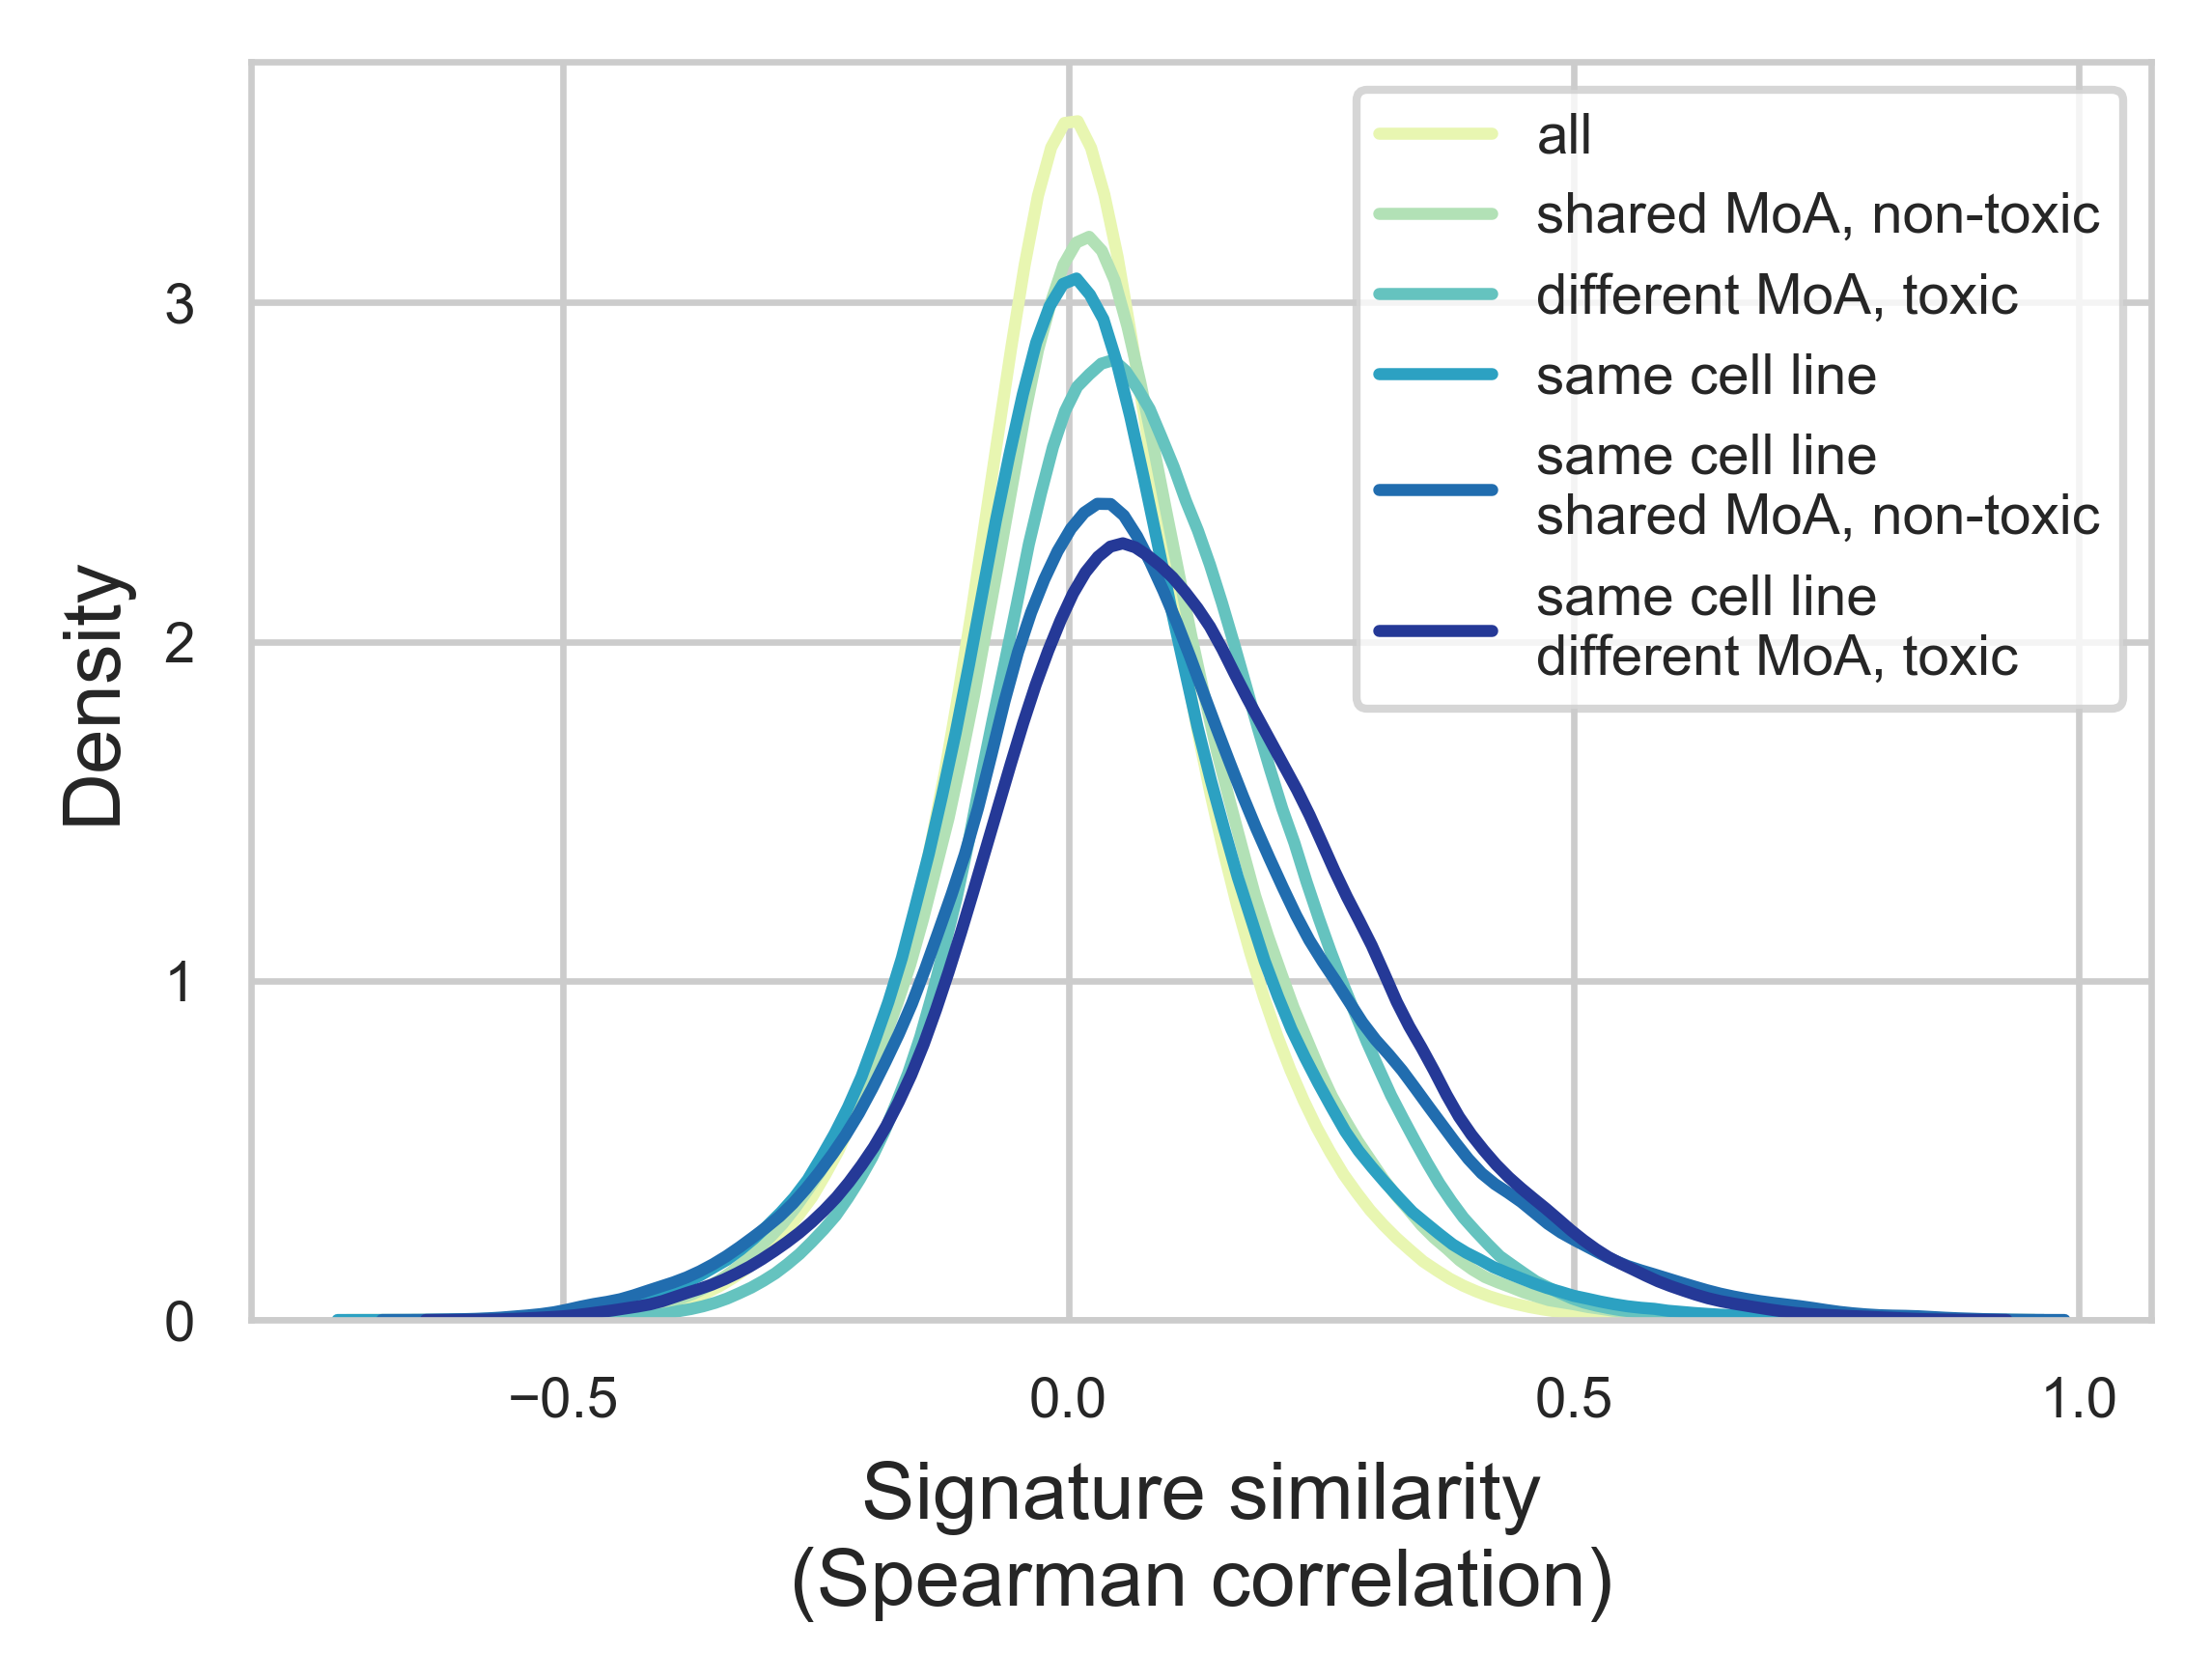

In [24]:
plt.figure(dpi=600,figsize=(4,3))
sns.set_palette('YlGnBu',6)
for group in ['all','shared MoA, non-toxic','different MoA, toxic',
             'same cell line','same cell line\nshared MoA, non-toxic','same cell line\ndifferent MoA, toxic']:
    g=sns.distplot(results[group],label=group,hist=False)
g.legend(loc=1, prop={'size': 7})
plt.xticks(size=7)
plt.yticks(size=7)
plt.xlabel('Signature similarity\n(Spearman correlation)',size=10)
plt.ylabel('Density',size=10)
plt.tight_layout()
plt.savefig('../figures/raw/Fig3A.pdf')

If we remove genes with high (absolute) correlation with cell viability from the signatures, we get better results.

In [3]:
gene_correlations=pd.read_table('../results/functional/achilles_cors_lm.csv',
                               sep=',',header=0,index_col=[0])
gene_correlations.index=gene_correlations.index.astype(str)
gene_correlations['abs_Person_r']=np.abs(gene_correlations['Pearson_r'])
gene_correlations=gene_correlations['abs_Person_r']
gene_correlations=gene_correlations.sort_values(ascending=False)

In [26]:
results={}
for i in range(0,1000,100):
    print('Calculating for %i removed genes...' %i,flush=True)
    results[i]={}
    genes=gene_correlations.index[i:]
    similarity=pd.DataFrame(scor(signatures[genes].T)[0],index=signatures.index,
                        columns=signatures.index)
    results[i]['all']=\
            get_similarity_values_for_mask(similarity)
    results[i]['shared MoA, non-toxic']=\
            get_similarity_values_for_mask(similarity,[moa_mask,non_tox_mask])
    results[i]['different MoA, toxic']=\
            get_similarity_values_for_mask(similarity,[~moa_mask,tox_mask])
    results[i]['same cell line']=\
            get_similarity_values_for_mask(similarity,[cell_mask])
    results[i]['same cell line\nshared MoA, non-toxic']=\
            get_similarity_values_for_mask(similarity,[cell_mask,moa_mask,non_tox_mask])
    results[i]['same cell line\ndifferent MoA, toxic']=\
            get_similarity_values_for_mask(similarity,[cell_mask,~moa_mask,tox_mask])

Calculating for 0 removed genes...
Calculating for 100 removed genes...
Calculating for 200 removed genes...
Calculating for 300 removed genes...
Calculating for 400 removed genes...
Calculating for 500 removed genes...
Calculating for 600 removed genes...
Calculating for 700 removed genes...
Calculating for 800 removed genes...
Calculating for 900 removed genes...


As an alternative strategy, we can try to regress out the effect of cell viaiblity from gene expression signatures. For this we will fit a *expression ~ cell viability* linear model for each gene, and than use the residuals of these models as gene expression signature.

In [29]:
import statsmodels.formula.api as smf

In [30]:
signatures_residuals=pd.DataFrame(index=signatures.index,columns=signatures.columns)
temp_signatures=signatures.copy()
temp_signatures.columns='X'+temp_signatures.columns #for statmodels we can not use numbers (even as string) for cols
temp_signatures['cpd_avg_pv']=sig_info['cpd_avg_pv']
for gene in signatures.columns:
    model=smf.ols('X'+gene+' ~ cpd_avg_pv',data=temp_signatures).fit()
    signatures_residuals[gene]=model.resid

In [62]:
similarity=pd.DataFrame(scor(signatures_residuals.T)[0],index=signatures.index,
                        columns=signatures.index)
results['resid']={}
results['resid']['all']=\
            get_similarity_values_for_mask(similarity)
results['resid']['shared MoA, non-toxic']=\
            get_similarity_values_for_mask(similarity,[moa_mask,non_tox_mask])
results['resid']['different MoA, toxic']=\
            get_similarity_values_for_mask(similarity,[~moa_mask,tox_mask])
results['resid']['same cell line']=\
            get_similarity_values_for_mask(similarity,[cell_mask])
results['resid']['same cell line\nshared MoA, non-toxic']=\
            get_similarity_values_for_mask(similarity,[cell_mask,moa_mask,non_tox_mask])
results['resid']['same cell line\ndifferent MoA, toxic']=\
            get_similarity_values_for_mask(similarity,[cell_mask,~moa_mask,tox_mask])

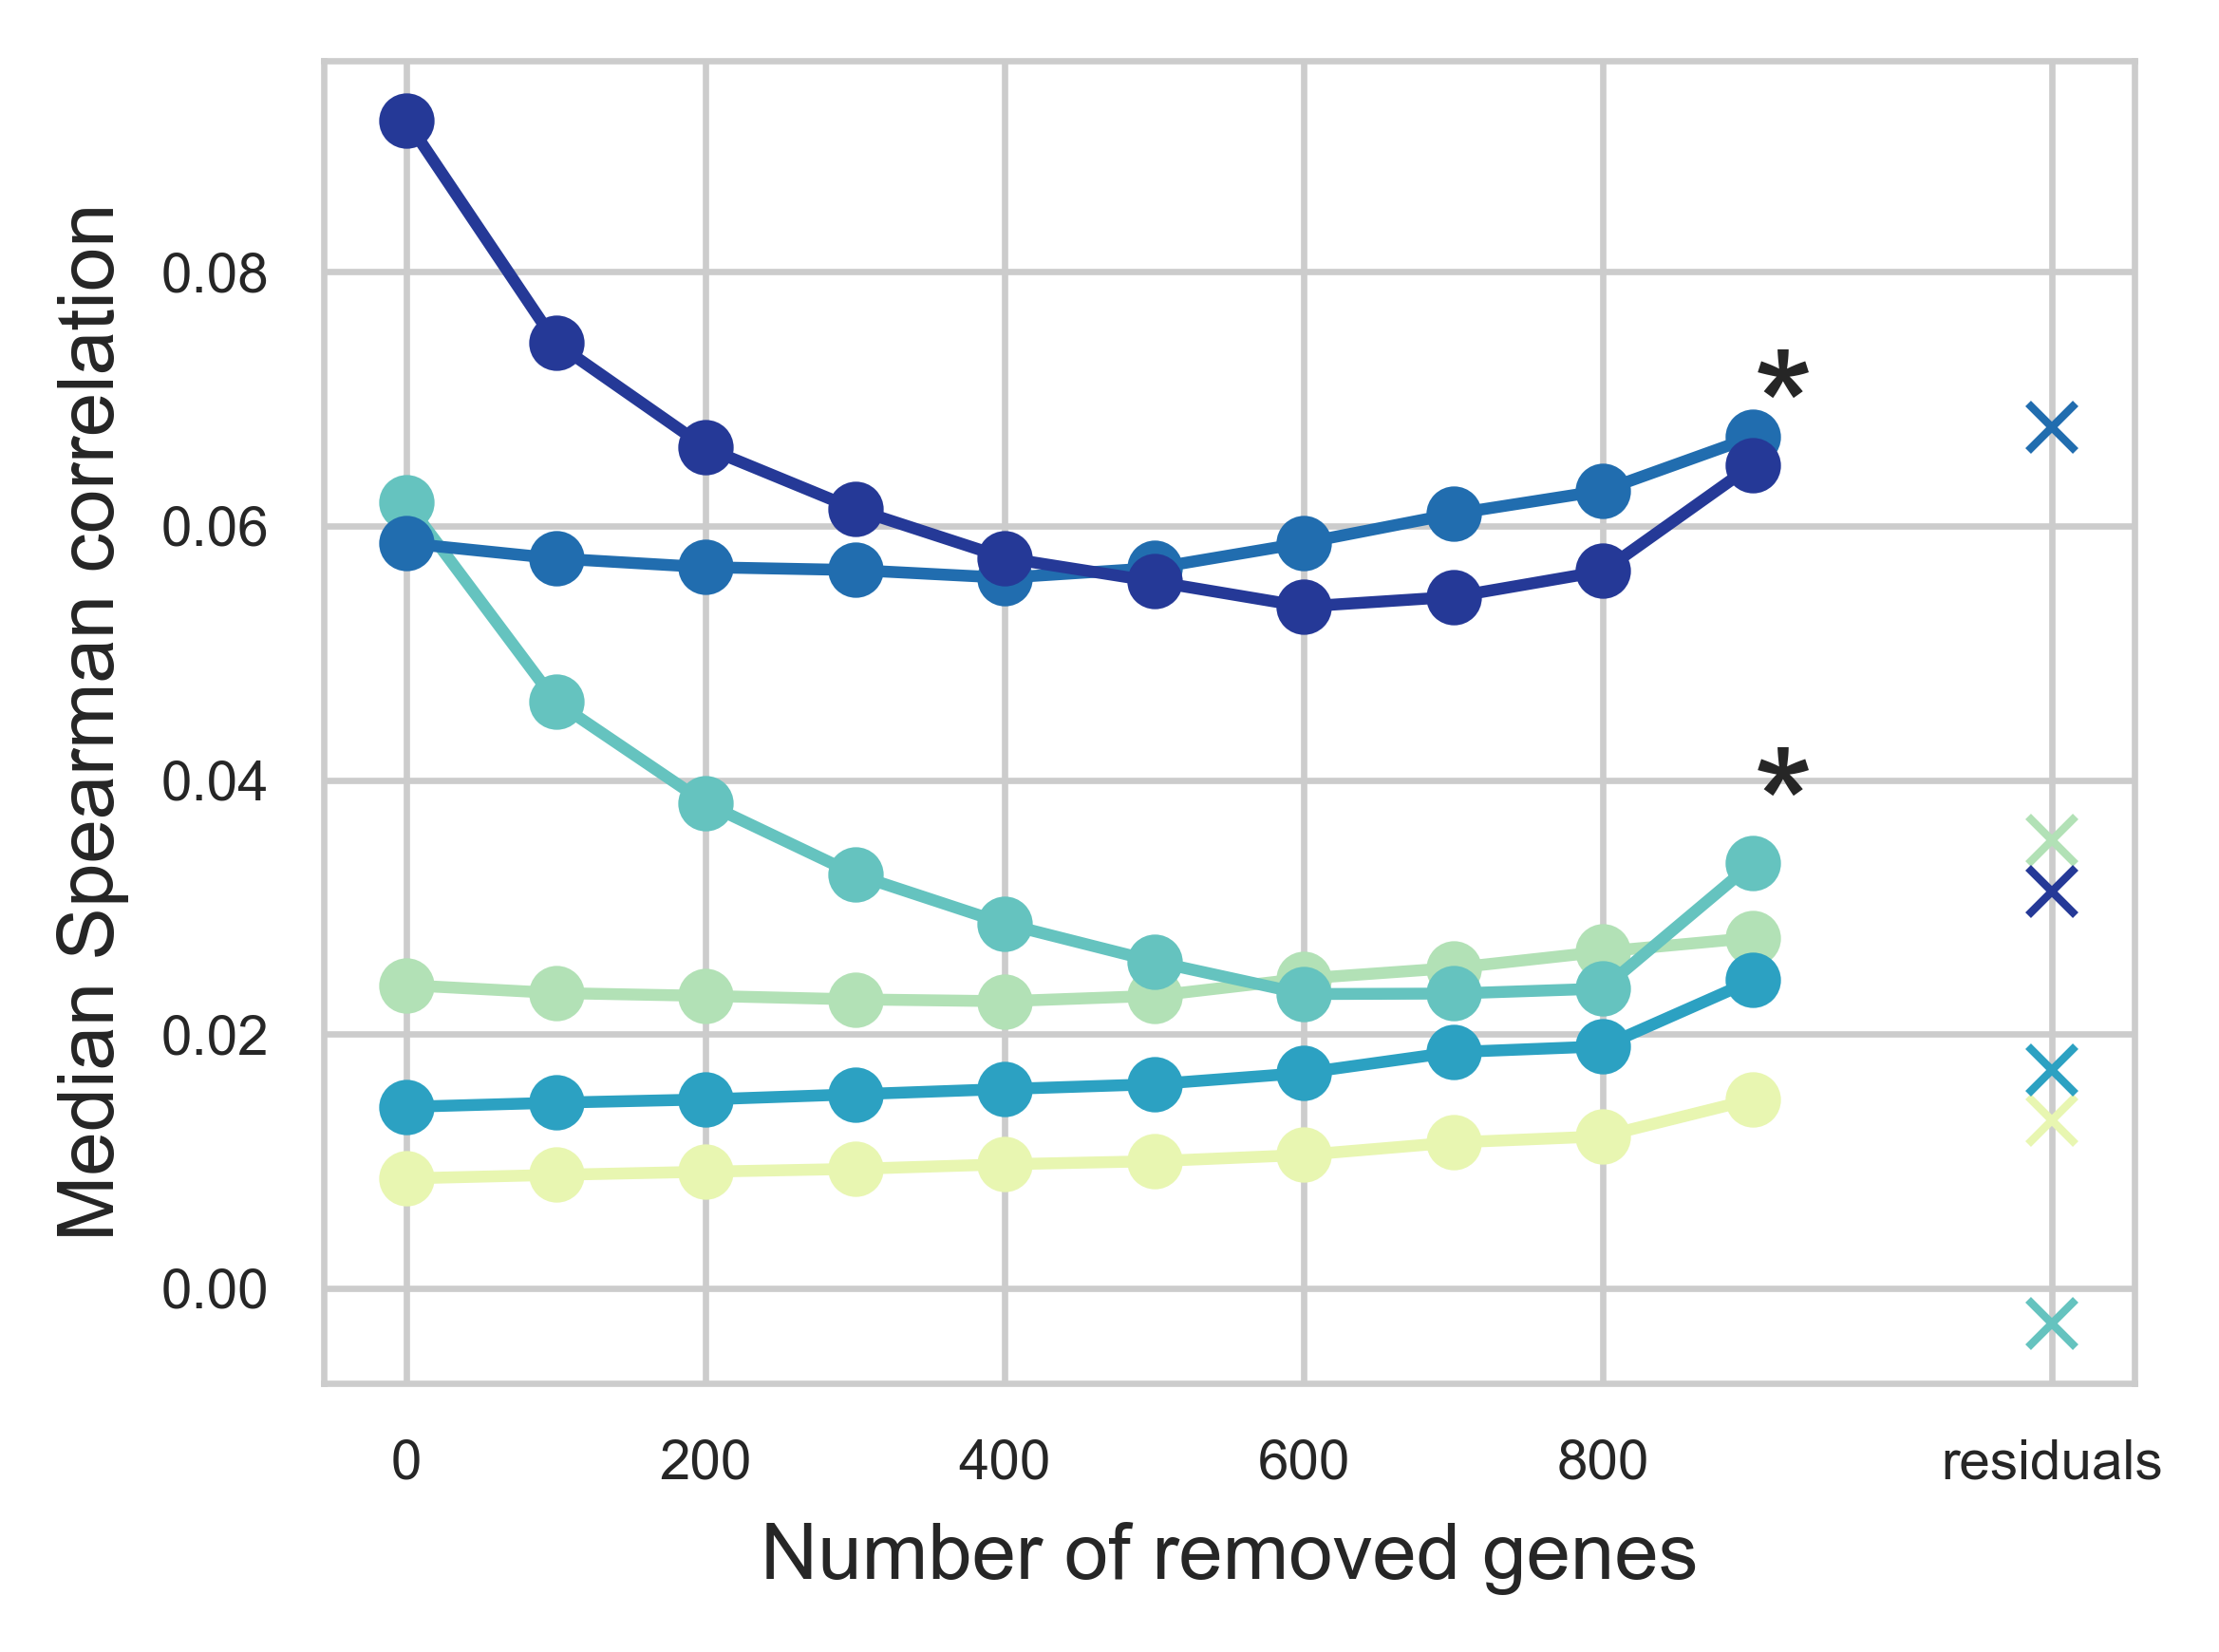

In [132]:
plt.figure(dpi=600,figsize=(4,3))
lm_data=pd.DataFrame(columns=['Med','Grp','Rem'])
sns.set_palette('YlGnBu',6)
for group in ['all','shared MoA, non-toxic','different MoA, toxic',
             'same cell line','same cell line\nshared MoA, non-toxic','same cell line\ndifferent MoA, toxic']:
    v=[]
    for i in range(0,1000,100):
        v.append(np.median(results[i][group]))
        temp=pd.DataFrame(index=[0],columns=lm_data.columns)
        temp.loc[0]=v[-1],group,i
        lm_data=pd.concat([lm_data,temp],ignore_index=True)
    plt.plot(range(0,1000,100),v,'o-')
for group in ['all','shared MoA, non-toxic','different MoA, toxic',
             'same cell line','same cell line\nshared MoA, non-toxic','same cell line\ndifferent MoA, toxic']:
    plt.plot([1100],[np.median(results['resid'][group])],'x')
plt.text(900,np.median(results[900]['different MoA, toxic']),'*',size=20)
plt.text(900,np.median(results[900]['same cell line\ndifferent MoA, toxic']),'*',size=20)
plt.xticks([0,200,400,600,800,1100],[0,200,400,600,800,'residuals'],size=7)
plt.yticks(size=7)
plt.xlabel('Number of removed genes',size=10)
plt.ylabel('Median Spearman correlation',size=10)
plt.tight_layout()
plt.savefig('../figures/raw/Fig3B.pdf')

In [131]:
lm_data['Rem']=lm_data['Rem'].astype(int)
lm_data['Med']=lm_data['Med'].astype(float)
lm_data['Grp']=lm_data['Grp'].astype(str)
model=smf.ols('Med ~ Grp * Rem',data=lm_data).fit()
model.pvalues

Intercept                                           1.219911e-02
Grp[T.different MoA, toxic]                         3.170068e-12
Grp[T.same cell line]                               2.471975e-01
Grp[T.same cell line\ndifferent MoA, toxic]         1.334701e-20
Grp[T.same cell line\nshared MoA, non-toxic]        1.139721e-14
Grp[T.shared MoA, non-toxic]                        1.791054e-03
Rem                                                 3.322342e-01
Grp[T.different MoA, toxic]:Rem                     3.227186e-05
Grp[T.same cell line]:Rem                           6.966030e-01
Grp[T.same cell line\ndifferent MoA, toxic]:Rem     1.649292e-04
Grp[T.same cell line\nshared MoA, non-toxic]:Rem    7.175373e-01
Grp[T.shared MoA, non-toxic]:Rem                    8.829625e-01
dtype: float64

If we remove random genes from the signatures, we do not see this effect.

In [10]:
np.random.seed(19890904)
gene_correlations=pd.read_table('../results/functional/achilles_cors_lm.csv',
                               sep=',',header=0,index_col=[0])
gene_correlations.index=gene_correlations.index.astype(str)
results={}
for i in range(100,1000,100):
    print('Calculating for %i removed genes...' %i,flush=True)
    results[i]={}
    results[i]['all']=[]
    results[i]['shared MoA, non-toxic']=[]
    results[i]['different MoA, toxic']=[]
    results[i]['same cell line']=[]
    results[i]['same cell line\nshared MoA, non-toxic']=[]
    results[i]['same cell line\ndifferent MoA, toxic']=[]
    for j in range(10):
        genes=np.random.choice(gene_correlations.index,len(gene_correlations)-i,False)
        similarity=pd.DataFrame(scor(signatures[genes].T)[0],index=signatures.index,
                        columns=signatures.index)
        results[i]['all'].append(np.median(get_similarity_values_for_mask(similarity)))
        results[i]['shared MoA, non-toxic'].append(np.median(get_similarity_values_for_mask(similarity,[moa_mask,non_tox_mask])))
        results[i]['different MoA, toxic'].append(np.median(get_similarity_values_for_mask(similarity,[~moa_mask,tox_mask])))
        results[i]['same cell line'].append(np.median(get_similarity_values_for_mask(similarity,[cell_mask])))
        results[i]['same cell line\nshared MoA, non-toxic'].append(np.median(get_similarity_values_for_mask(similarity,[cell_mask,moa_mask,non_tox_mask])))
        results[i]['same cell line\ndifferent MoA, toxic'].append(np.median(get_similarity_values_for_mask(similarity,[cell_mask,~moa_mask,tox_mask])))
i=0
results[i]={}
results[i]['all']=[]
results[i]['shared MoA, non-toxic']=[]
results[i]['different MoA, toxic']=[]
results[i]['same cell line']=[]
results[i]['same cell line\nshared MoA, non-toxic']=[]
results[i]['same cell line\ndifferent MoA, toxic']=[]

genes=np.random.choice(gene_correlations.index,len(gene_correlations)-i,False)
similarity=pd.DataFrame(scor(signatures[genes].T)[0],index=signatures.index,
                        columns=signatures.index)

results[i]['all'].append(np.median(get_similarity_values_for_mask(similarity)))
results[i]['shared MoA, non-toxic'].append(np.median(get_similarity_values_for_mask(similarity,[moa_mask,non_tox_mask])))
results[i]['different MoA, toxic'].append(np.median(get_similarity_values_for_mask(similarity,[~moa_mask,tox_mask])))
results[i]['same cell line'].append(np.median(get_similarity_values_for_mask(similarity,[cell_mask])))
results[i]['same cell line\nshared MoA, non-toxic'].append(np.median(get_similarity_values_for_mask(similarity,[cell_mask,moa_mask,non_tox_mask])))
results[i]['same cell line\ndifferent MoA, toxic'].append(np.median(get_similarity_values_for_mask(similarity,[cell_mask,~moa_mask,tox_mask])))


Calculating for 100 removed genes...
Calculating for 200 removed genes...
Calculating for 300 removed genes...
Calculating for 400 removed genes...
Calculating for 500 removed genes...
Calculating for 600 removed genes...
Calculating for 700 removed genes...
Calculating for 800 removed genes...
Calculating for 900 removed genes...


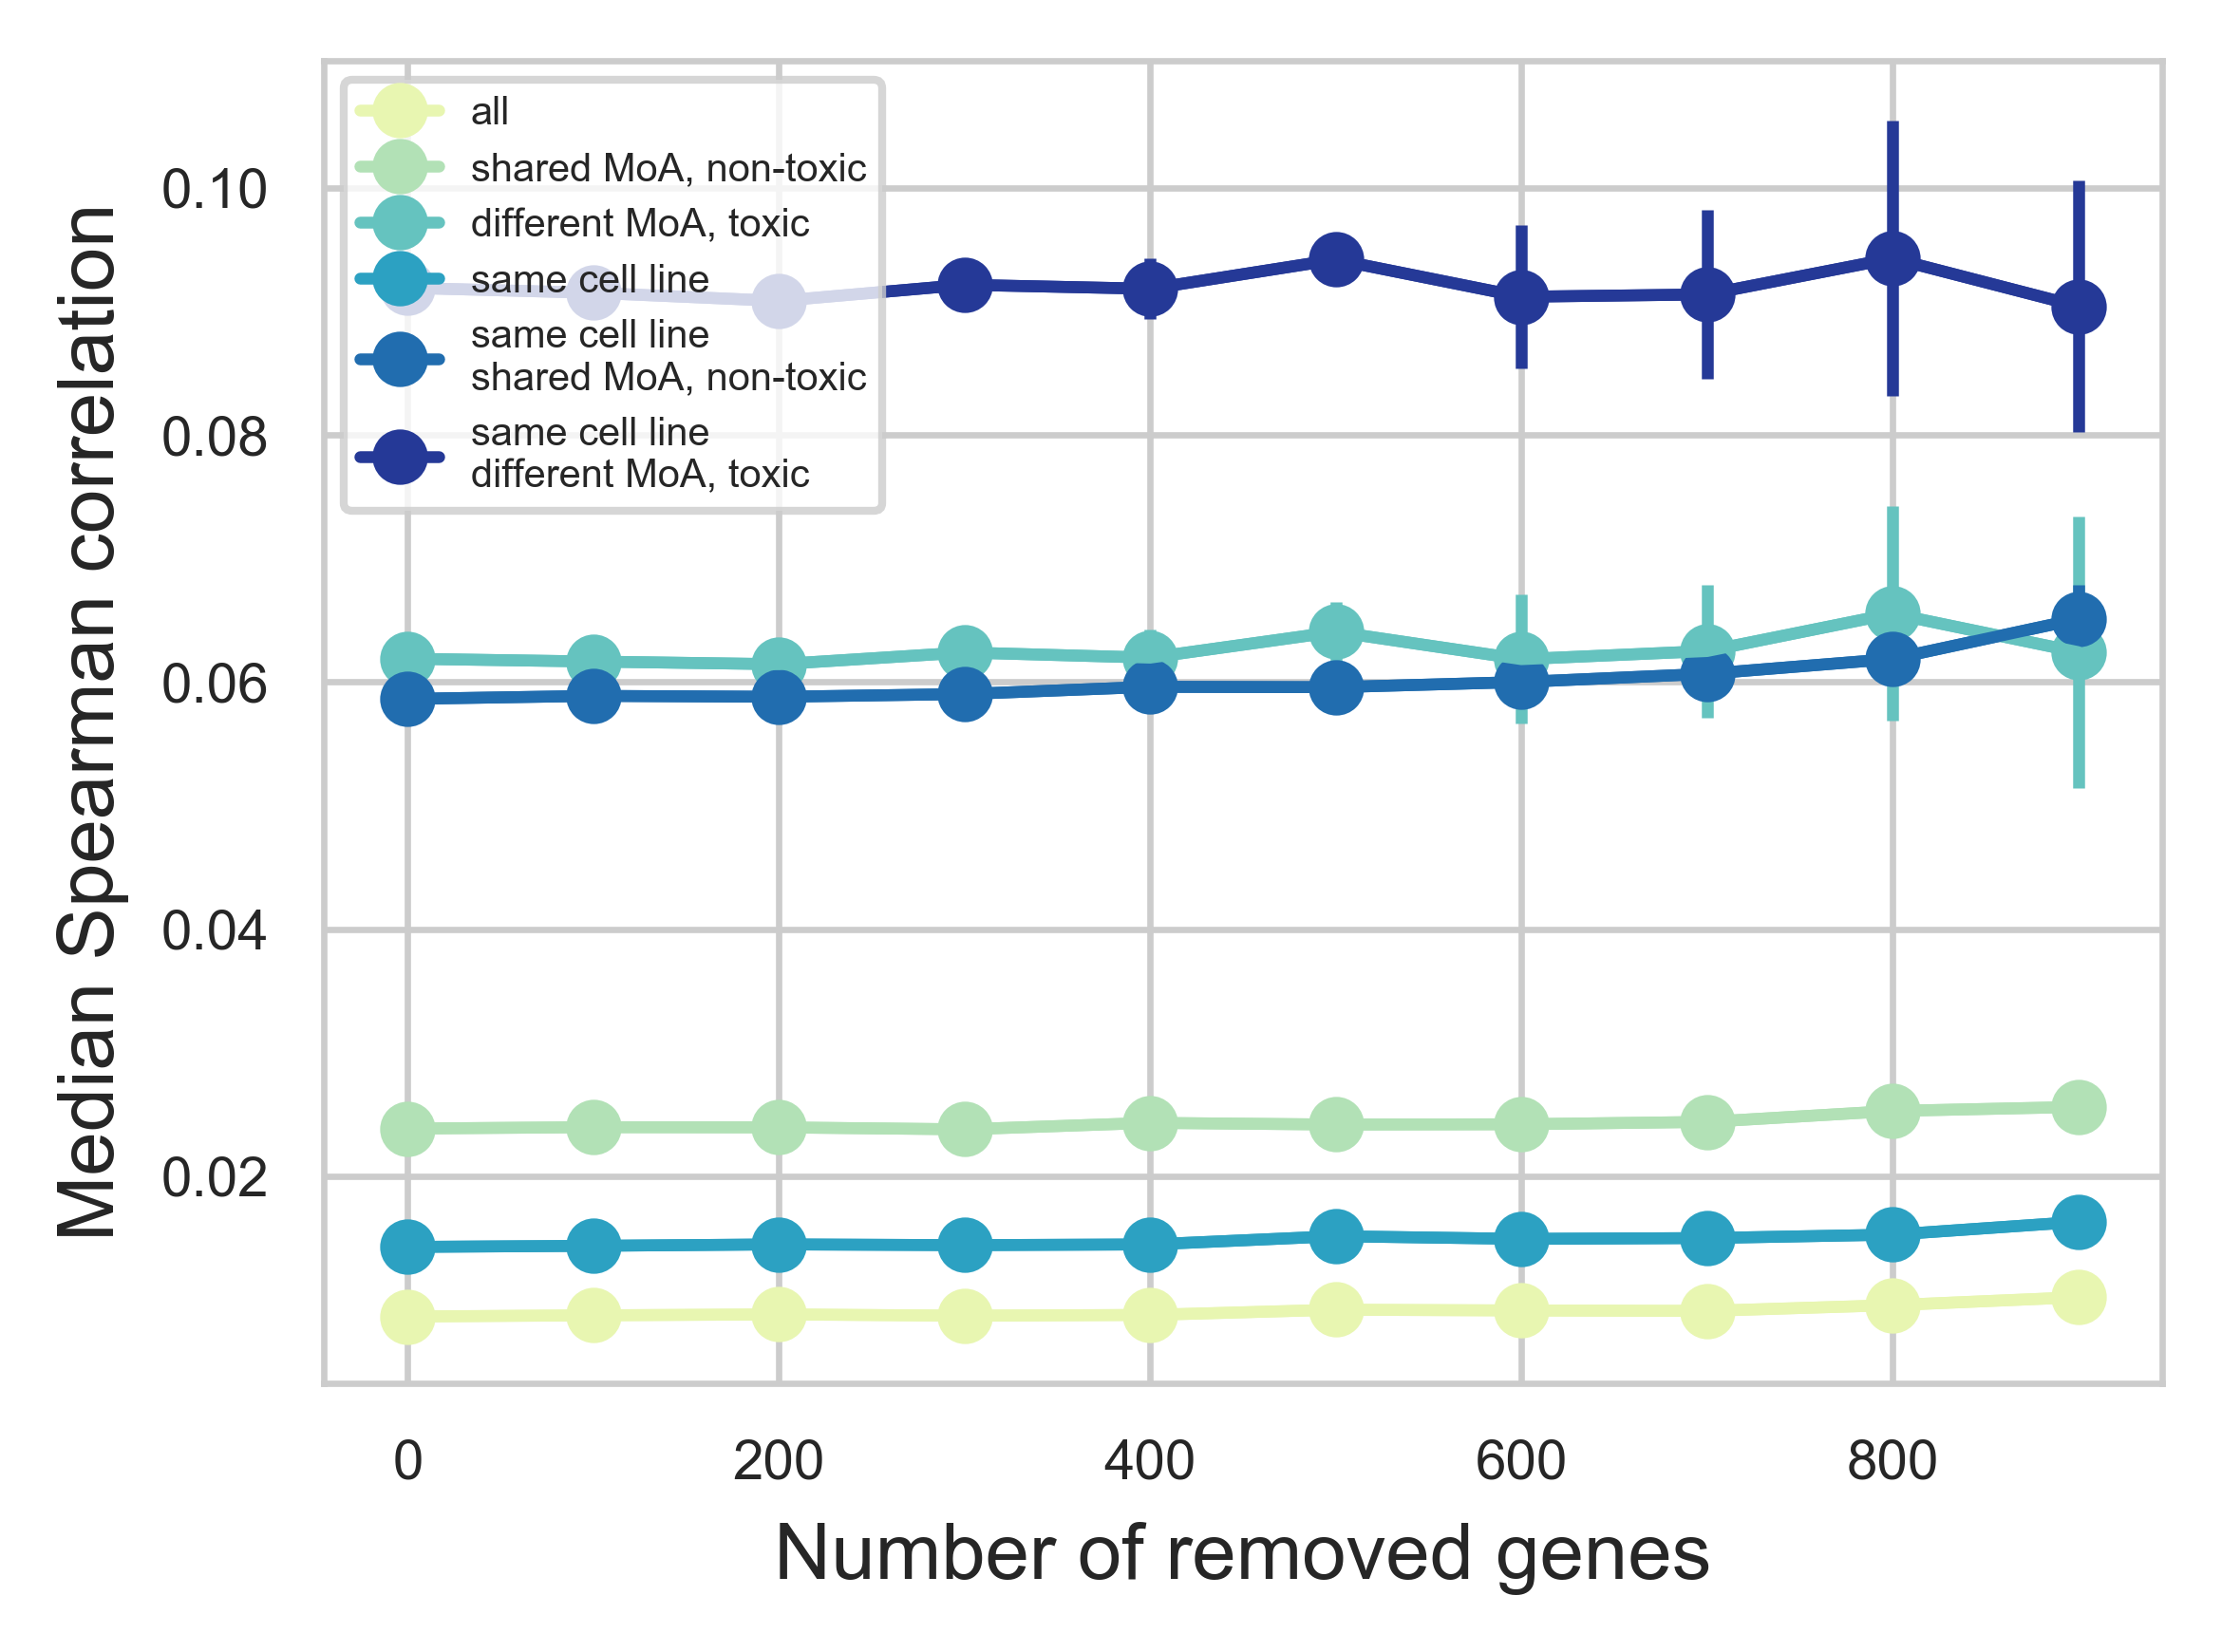

In [28]:
plt.figure(dpi=600,figsize=(4,3))
lm_data=pd.DataFrame(columns=['Med','Grp','Rem'])
sns.set_palette('YlGnBu',6)
for group in ['all','shared MoA, non-toxic','different MoA, toxic',
             'same cell line','same cell line\nshared MoA, non-toxic','same cell line\ndifferent MoA, toxic']:
    v=[]
    for i in range(0,1000,100):
        v.append(np.mean(results[i][group]))
    plt.plot(range(0,1000,100),v,'o-')
for group in ['all','shared MoA, non-toxic','different MoA, toxic',
             'same cell line','same cell line\nshared MoA, non-toxic','same cell line\ndifferent MoA, toxic']:
    v=[]
    s=[]
    for i in range(0,1000,100):
        v.append(np.mean(results[i][group]))
        s.append(np.std(results[i][group]))
    plt.errorbar(range(0,1000,100),v,s)
plt.xticks(size=7)
plt.yticks(size=7)
plt.xlabel('Number of removed genes',size=10)
plt.ylabel('Median Spearman correlation',size=10)
plt.legend(['all','shared MoA, non-toxic','different MoA, toxic',
             'same cell line','same cell line\nshared MoA, non-toxic','same cell line\ndifferent MoA, toxic'],
          loc=2, prop={'size': 5})
plt.tight_layout()

plt.savefig('../figures/raw/SFig4A.pdf')

In [33]:
lm_data=pd.DataFrame(columns=['Med','Grp','Rem'])
for i in range(0,1000,100):
    for group in ['all','shared MoA, non-toxic','different MoA, toxic',
             'same cell line','same cell line\nshared MoA, non-toxic','same cell line\ndifferent MoA, toxic']:
        temp=pd.DataFrame(index=range(len(results[i][group])),columns=lm_data.columns)
        temp['Med']=results[i][group]
        temp['Grp']=group
        temp['Rem']=i
        lm_data=pd.concat([lm_data,temp],ignore_index=True)
lm_data['Rem']=lm_data['Rem'].astype(int)
lm_data['Med']=lm_data['Med'].astype(float)
lm_data['Grp']=lm_data['Grp'].astype(str)
model=smf.ols('Med ~ Grp * Rem',data=lm_data).fit()
model.pvalues

Intercept                                            5.361596e-24
Grp[T.different MoA, toxic]                         1.043550e-193
Grp[T.same cell line]                                7.610570e-07
Grp[T.same cell line\ndifferent MoA, toxic]         1.703108e-284
Grp[T.same cell line\nshared MoA, non-toxic]        5.980145e-179
Grp[T.shared MoA, non-toxic]                         5.853982e-36
Rem                                                  2.821423e-01
Grp[T.different MoA, toxic]:Rem                      6.129498e-01
Grp[T.same cell line]:Rem                            8.371221e-01
Grp[T.same cell line\ndifferent MoA, toxic]:Rem      6.492800e-01
Grp[T.same cell line\nshared MoA, non-toxic]:Rem     1.981510e-02
Grp[T.shared MoA, non-toxic]:Rem                     8.468698e-01
dtype: float64

Based on this results we can also "simulate" MoA identification process. We will calculate a consensus signature for each compound in CTRP dataset, and calculate similarities (Spearman correlation, based on full and reduced signatures) between these consensus signatures. We will compare our results with chemical similarity and sensitivity based similarity.

In [31]:
# just for consensus signature calculation
def calc_MODZ(data):
    """calculates MODZ based on the original CMAP/L1000 study
    use only lm genes for MODZ calculation! Uses LM_GENES global
    variable."""
    if len(data)==1:
        return data
    if len(data)==2:
        return np.mean(data,0)
    else:
        CM=scor(data.T)[0]
        fil=CM<0
        CM[fil]=0.01
        weights=np.sum(CM,1)-1
        weights=weights/np.sum(weights)
        weights=weights.reshape((-1,1))
        return pd.Series(np.dot(data.T,weights).reshape((-1,1)[0]),index=data.columns)

In [32]:
consensus_signatures={}
gene_correlations=pd.read_table('../results/functional/achilles_cors_lm.csv',
                               sep=',',header=0,index_col=[0])
gene_correlations.index=gene_correlations.index.astype(str)
gene_correlations['abs_Person_r']=np.abs(gene_correlations['Pearson_r'])
gene_correlations=gene_correlations['abs_Person_r']
gene_correlations=gene_correlations.sort_values(ascending=False)
for i in range(0,1000,100):
    print('Calculating consensus signature for %i removed genes' %i)
    genes=gene_correlations.index[i:]
    consensus_signatures[i]=pd.DataFrame(index=list(set(sig_info['pert_id'])),columns=genes)
    for cpd in list(set(sig_info['pert_id'])):
        indexes=list(sig_info.index[sig_info['pert_id']==cpd])
        consensus_signatures[i].loc[cpd]=calc_MODZ(signatures.loc[indexes,genes]).values
consensus_signatures['res']=pd.DataFrame(index=list(set(sig_info['pert_id'])),columns=signatures_residuals.columns)
for cpd in list(set(sig_info['pert_id'])):
    indexes=list(sig_info.index[sig_info['pert_id']==cpd])
    consensus_signatures['res'].loc[cpd]=calc_MODZ(signatures_residuals.loc[indexes]).values

Calculating consensus signature for 0 removed genes
Calculating consensus signature for 100 removed genes
Calculating consensus signature for 200 removed genes
Calculating consensus signature for 300 removed genes
Calculating consensus signature for 400 removed genes
Calculating consensus signature for 500 removed genes
Calculating consensus signature for 600 removed genes
Calculating consensus signature for 700 removed genes
Calculating consensus signature for 800 removed genes
Calculating consensus signature for 900 removed genes


In [33]:
similarity={}
for i in range(0,1000,100):
    print('Calculating similarity for %i removed genes' %i)
    similarity[i]=pd.DataFrame(scor(consensus_signatures[i].T)[0],index=consensus_signatures[i].index,
                        columns=consensus_signatures[i].index)
similarity['reg']=pd.DataFrame(scor(consensus_signatures['res'].T)[0],index=consensus_signatures['res'].index,
                        columns=consensus_signatures['res'].index)

Calculating similarity for 0 removed genes
Calculating similarity for 100 removed genes
Calculating similarity for 200 removed genes
Calculating similarity for 300 removed genes
Calculating similarity for 400 removed genes
Calculating similarity for 500 removed genes
Calculating similarity for 600 removed genes
Calculating similarity for 700 removed genes
Calculating similarity for 800 removed genes
Calculating similarity for 900 removed genes


Here we use chemical fingerprints for similarity calculations. Scripts for creating these fingerprint vectors are in MorganFP_Generate.ipynb.

In [34]:
chemichal=pd.read_table('../data/Chemical/LINCS_PertID_SMILES_MorganFP_1024bits.csv',
                       sep=',',header=0,index_col=[0])
chemichal.index=chemichal['CompoundNames']
chemichal=chemichal.iloc[:,:-1].astype(bool)
cpds=list(set(similarity[0].index)&set(chemichal.index))
chemichal=chemichal.loc[cpds]
similarity['chem_1024']=pd.DataFrame(index=cpds,columns=cpds)
for i in similarity['chem_1024'].index:
    similarity['chem_1024'].loc[i]=np.sum(chemichal.loc[i]&chemichal,1)/np.sum(chemichal.loc[i]|chemichal,1)

In [35]:
#these are 256 bit vectors, but won't use them
chemichal=pd.read_table('../data/Chemical/LINCS_PertID_SMILES_MorganFP_256bits.csv',
                       sep=',',header=0,index_col=[0])
chemichal.index=chemichal['CompoundNames']
chemichal=chemichal.iloc[:,:-1].astype(bool)
cpds=list(set(similarity[0].index)&set(chemichal.index))
chemichal=chemichal.loc[cpds]
similarity['chem_256']=pd.DataFrame(index=cpds,columns=cpds)
for i in similarity['chem_256'].index:
    similarity['chem_256'].loc[i]=np.sum(chemichal.loc[i]&chemichal,1)/np.sum(chemichal.loc[i]|chemichal,1)

And we will also calculate similarities based on drug sensitivity.

In [36]:
from scipy.stats import pearsonr as pcor

In [37]:
sensitivity=pd.read_table('../results/CTRP/ctrp_DR.csv',sep=',',
                         header=0,index_col=[0])
sensitivity=sensitivity.drop_duplicates(['ccl_name','broad_cpd_id'])
sensitivity=sensitivity.pivot(index='ccl_name',columns='broad_cpd_id',values='area_under_curve')
cpds=list(set(similarity[0].index)&set(chemichal.index)&set(sensitivity.columns))
sensitivity=sensitivity[cpds]
similarity['sens']=pd.DataFrame(index=cpds,columns=cpds)
for cpd1 in cpds:
    cells1=sensitivity.index[~pd.isnull(sensitivity[cpd1])]
    for cpd2 in cpds:
        cells2=sensitivity.index[~pd.isnull(sensitivity[cpd2])]
        cells=list(set(cells1)&set(cells2))
        if len(cells)>10: #need at least 10 cells for correlation (arbitary)
            similarity['sens'].loc[cpd1,cpd2]=pcor(sensitivity.loc[cells,cpd1],sensitivity.loc[cells,cpd2])[0]

In [38]:
cpds=similarity['sens'].index[np.sum(pd.isnull(similarity['sens']))==0]
similarity['sens']=similarity['sens'].loc[cpds,cpds]

In [39]:
shared_moa=pd.read_table('../results/moa/shared_moa_ctrp.csv',sep=',',header=0,index_col=0)
similarity['moa']=shared_moa

In [40]:
cpds=list(set(similarity['sens'].index)&set(similarity['chem_1024'].index)&set(similarity[0].index)&set(shared_moa.index))
for group in similarity.keys():
    similarity[group]=similarity[group].loc[cpds,cpds]

In [41]:
results=pd.DataFrame(index=range(len(similarity[0].values[np.triu_indices(len(similarity[0]),1)])),
                     columns=similarity.keys())
for g in similarity.keys():
    results[g]=similarity[g].values[np.triu_indices(len(similarity[g]),1)]
results.to_csv('../results/moa/moa_ctrp_predictions.csv',sep=',')

In [2]:
results=pd.read_csv('../results/moa/moa_ctrp_predictions.csv',sep=',',header=0,index_col=0)

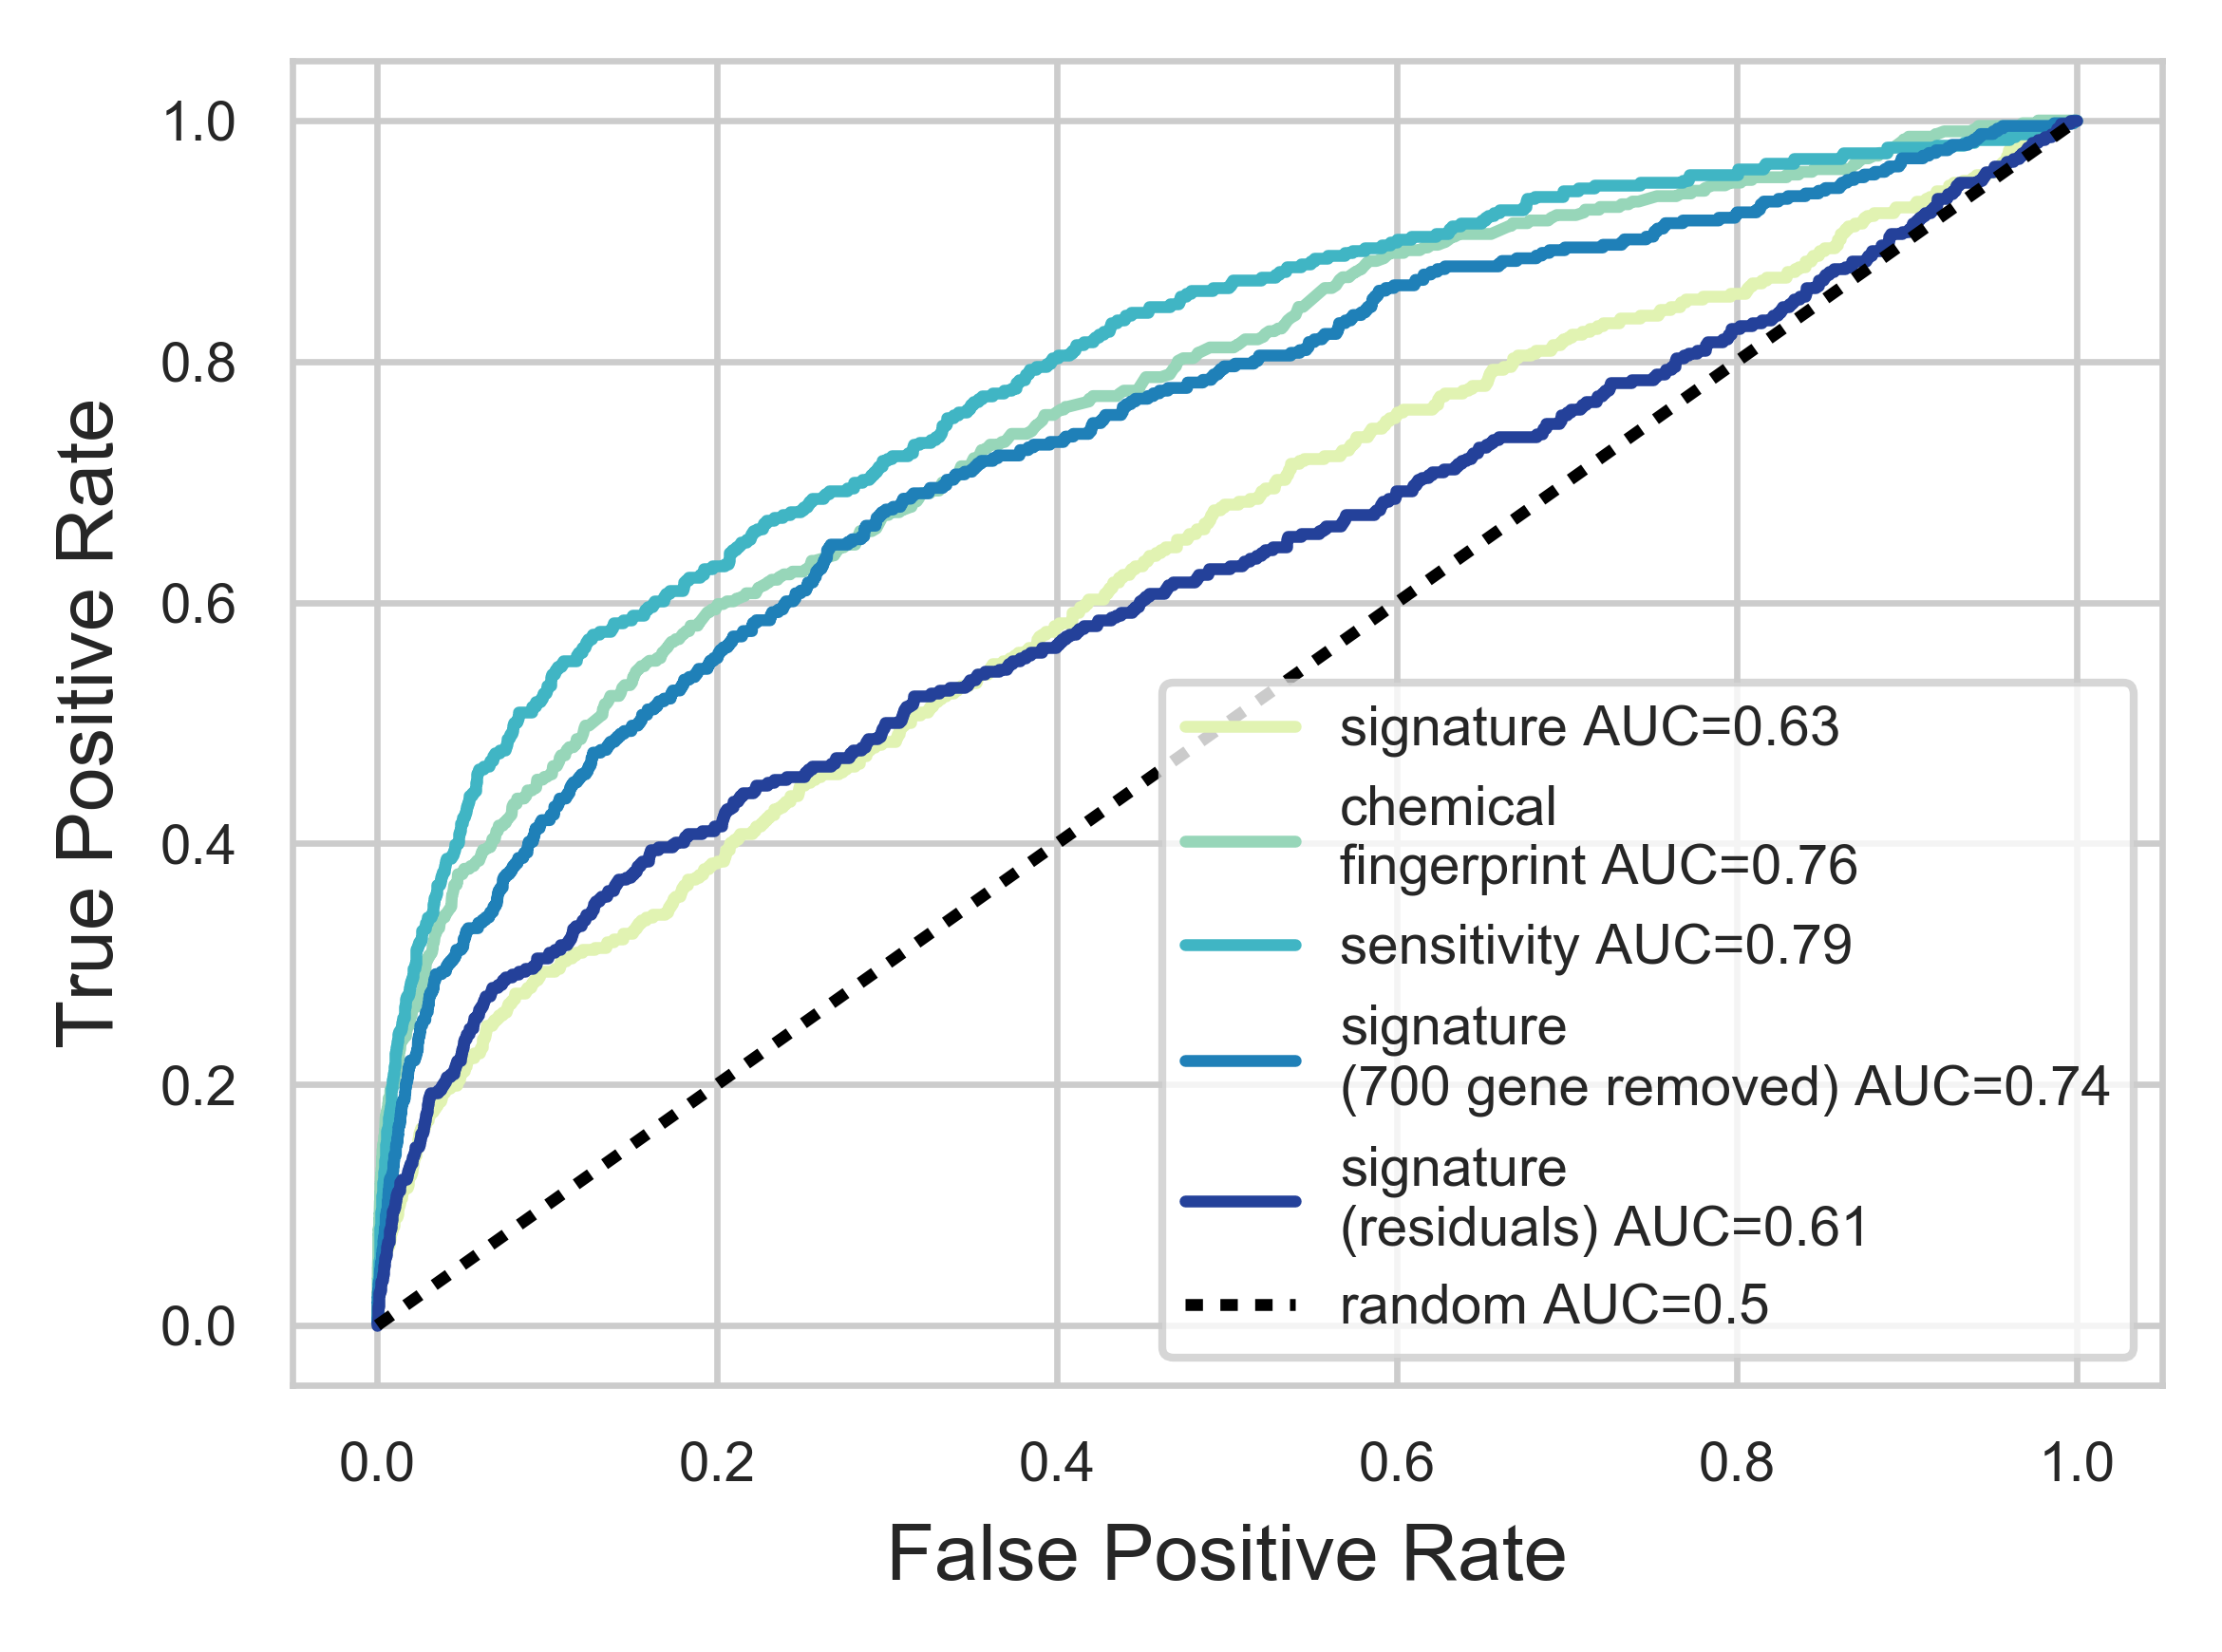

In [12]:
plt.figure(dpi=600,figsize=(4,3))
sns.set_palette('YlGnBu',5)
aucs=[]
labels=['signature','chemical\nfingerprint','sensitivity',
            'signature\n(700 gene removed)','signature\n(residuals)']
for g in ['0','chem_1024','sens','700','reg']:
    fpr,tpr,dummy=ROC(results['moa'],results[g])
    plt.plot(fpr,tpr)
    aucs.append(str(AUC(fpr,tpr))[:4])
plt.plot([0,1],[0,1],':k')
full_labels=[]
for i in range(len(labels)):
    full_labels.append(labels[i] + ' AUC='+aucs[i])
full_labels.append('random AUC=0.5')
plt.legend(full_labels,
          loc=0, prop={'size': 7})
plt.xticks(size=7)
plt.yticks(size=7)
plt.xlabel('False Positive Rate',size=10)
plt.ylabel('True Positive Rate',size=10)
plt.tight_layout()
plt.savefig('../figures/raw/Fig3C.pdf')

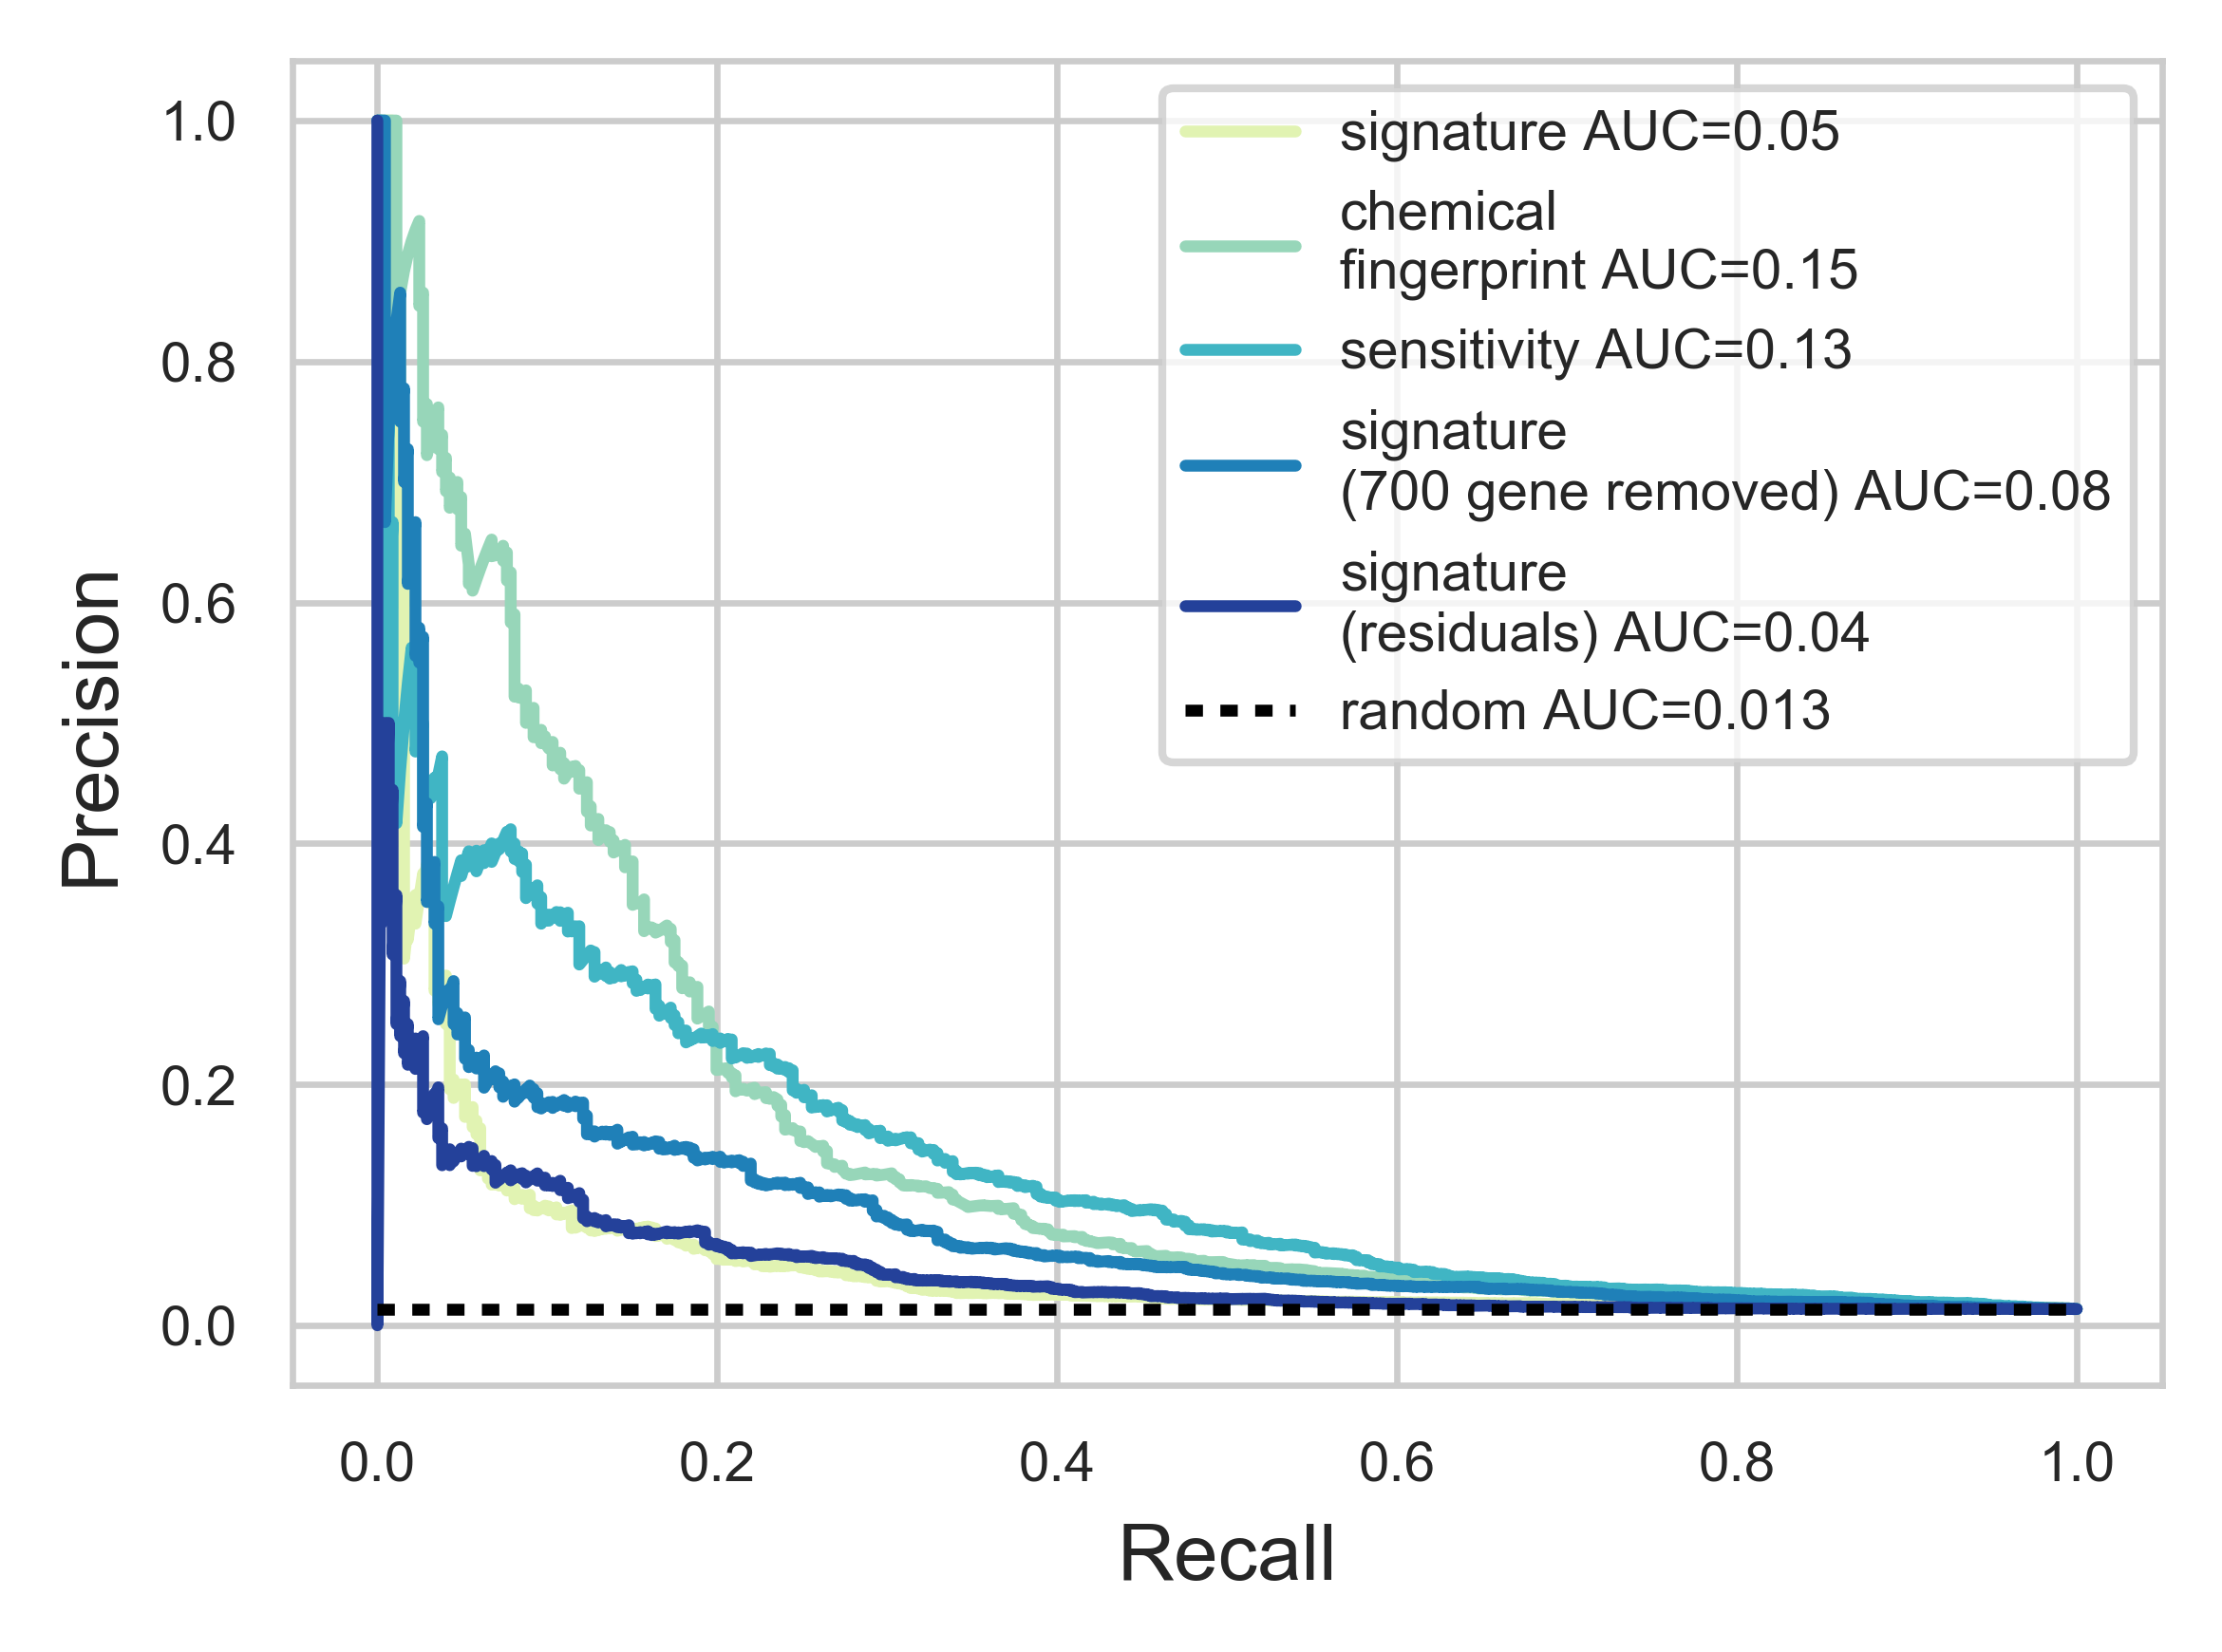

In [13]:
plt.figure(dpi=600,figsize=(4,3))
sns.set_palette('YlGnBu',5)
aucs=[]
labels=['signature','chemical\nfingerprint','sensitivity',
            'signature\n(700 gene removed)','signature\n(residuals)']
real_tpr=str(np.sum(results['moa'])/len(results['moa']))
for g in ['0','chem_1024','sens','700','reg']:
    pre,rec,dummy=PRC(results['moa'],results[g])
    plt.plot(rec,pre)
    aucs.append(str(AUC(rec,pre))[:4])
plt.plot([0,1],[real_tpr,real_tpr],':k')
full_labels=[]
for i in range(len(labels)):
    full_labels.append(labels[i] + ' AUC='+aucs[i])
full_labels.append('random AUC='+str(real_tpr)[:5])
plt.legend(full_labels,
          loc=0, prop={'size': 7})
plt.xticks(size=7)
plt.yticks(size=7)
plt.xlabel('Recall',size=10)
plt.ylabel('Precision',size=10)
plt.tight_layout()
plt.savefig('../figures/raw/Fig3D.pdf')

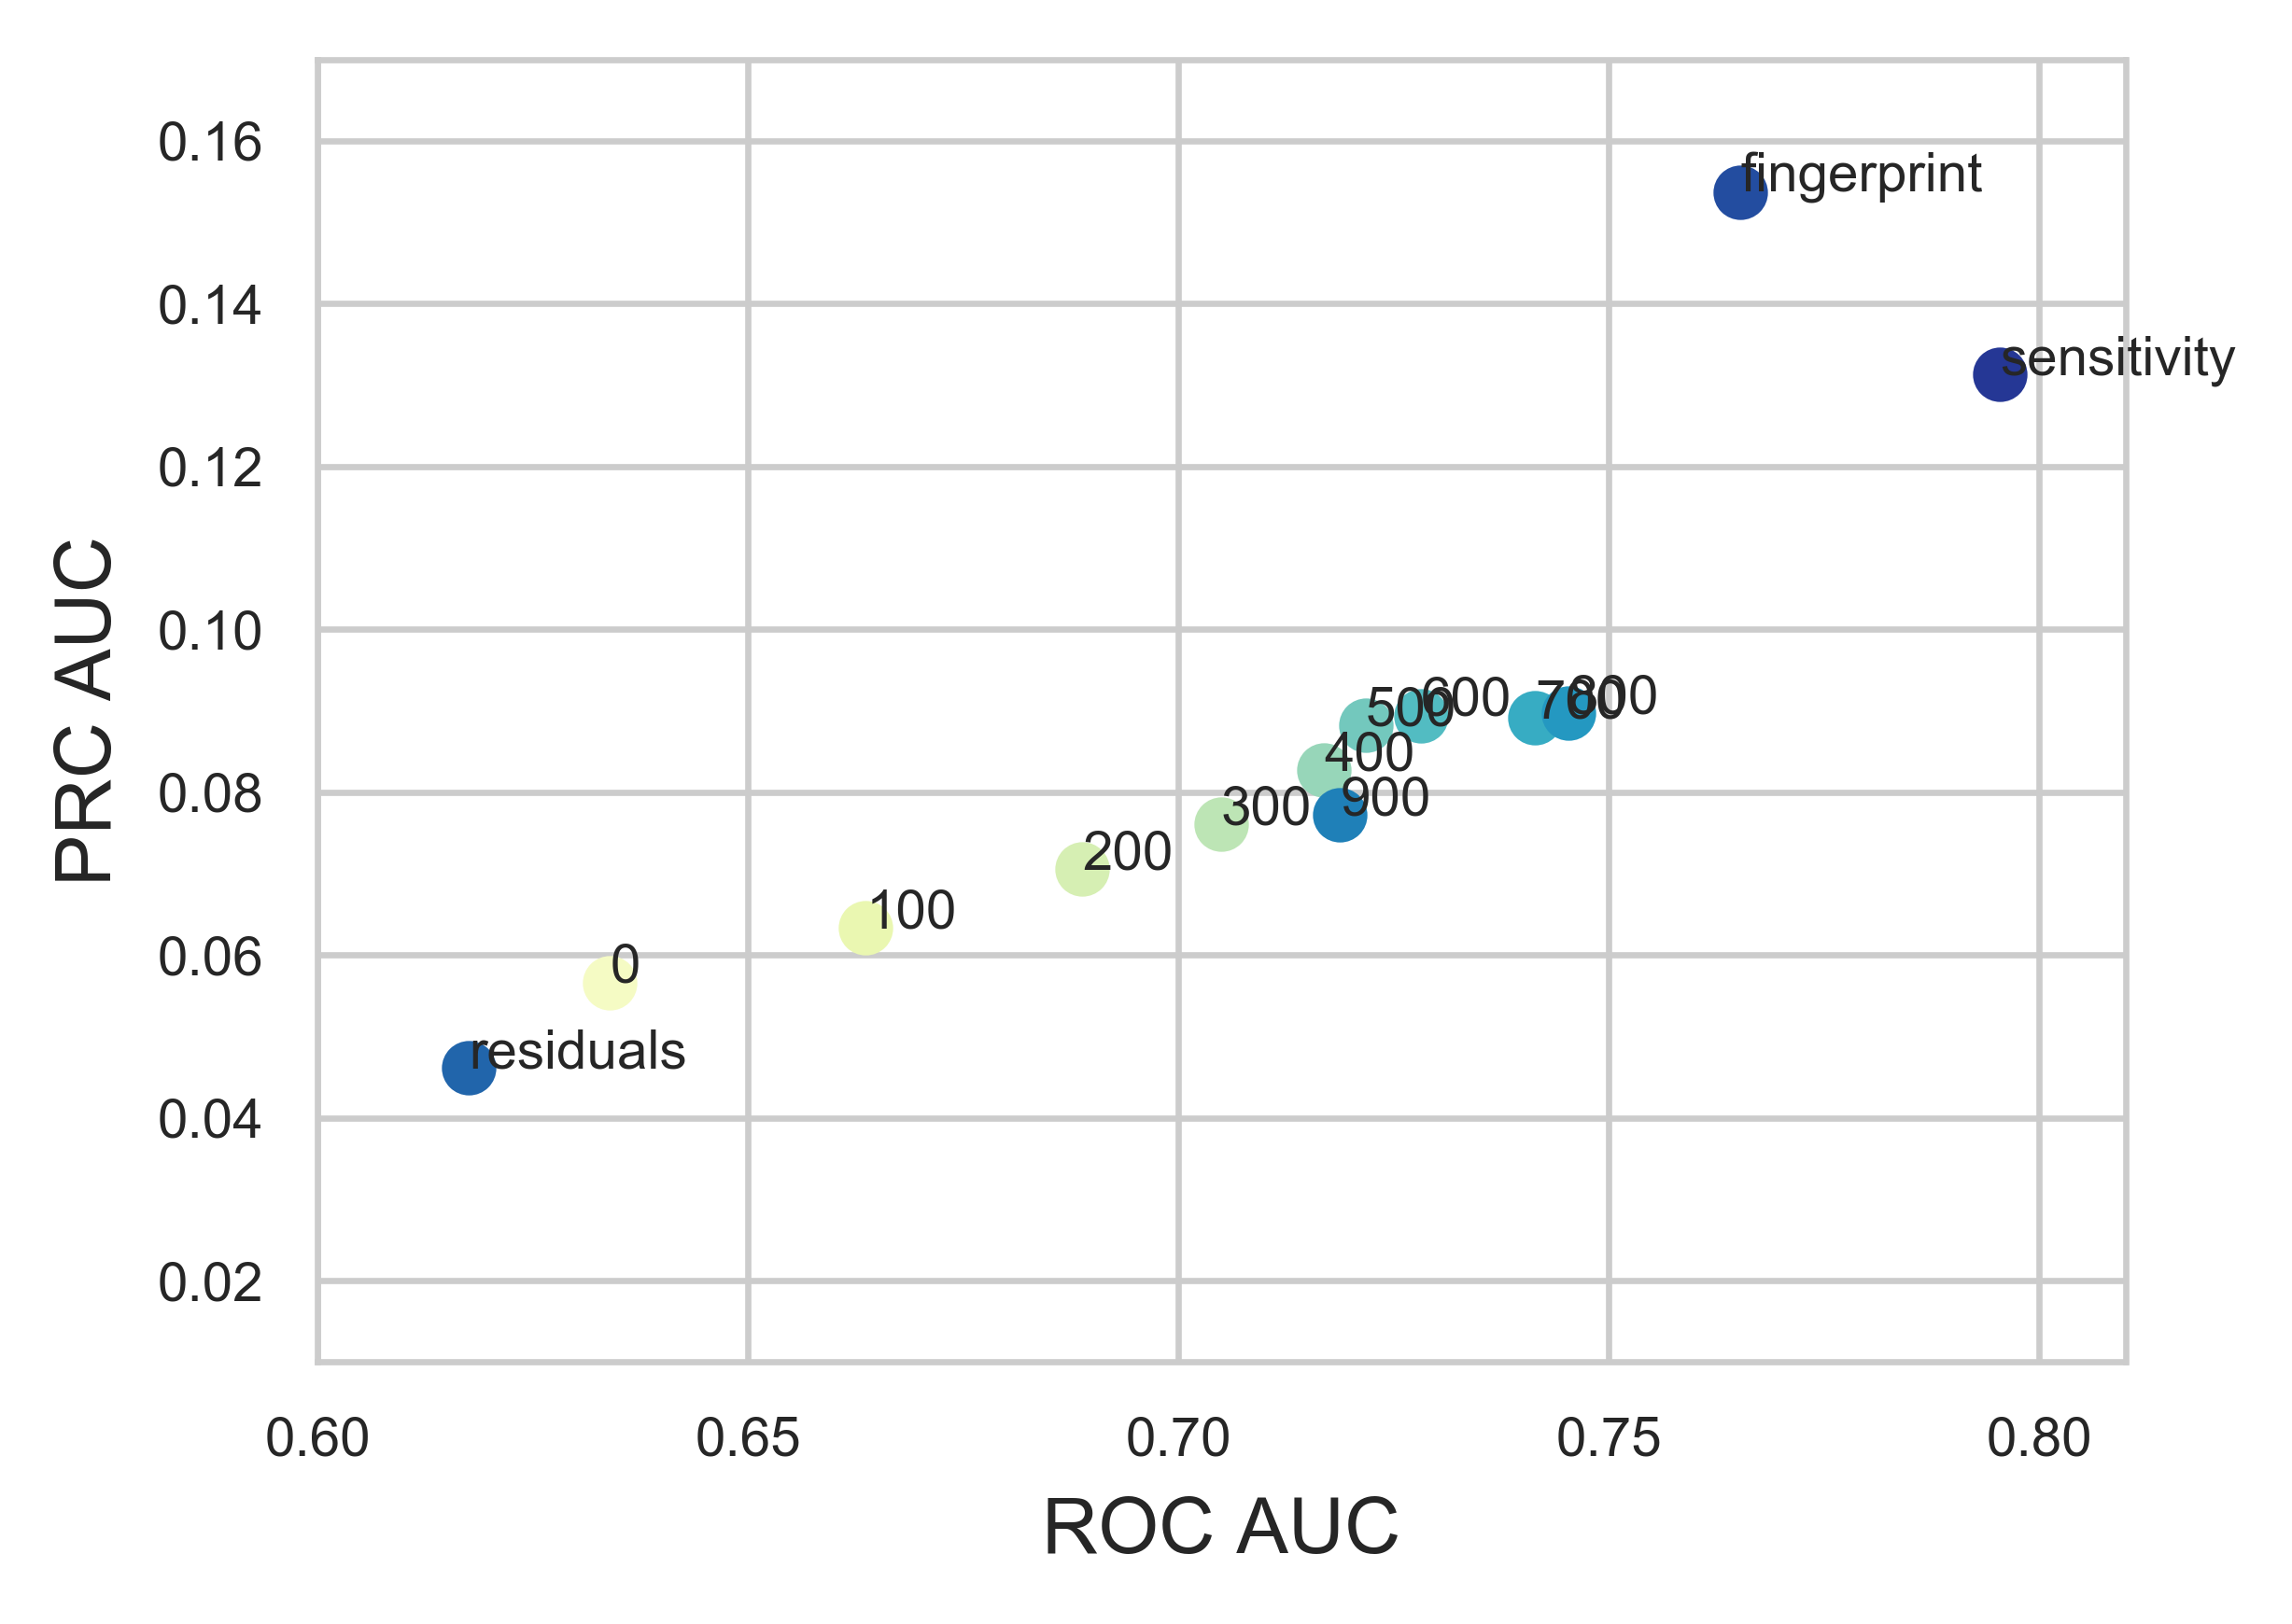

In [23]:
plt.figure(dpi=600,figsize=(4,3))
sns.set_palette('YlGnBu',14)
names=list(range(0,1000,100))+['residuals','fingerprint','sensitivity']
groups=list(range(0,1000,100))+['reg','chem_1024','sens']
for i in range(len(groups)):
    n=names[i]
    g=str(groups[i])
    pre,rec,dummy=PRC(results['moa'],results[g])
    fpr,tpr,dummy=ROC(results['moa'],results[g])
    x=AUC(fpr,tpr)
    y=AUC(rec,pre)
    plt.plot([x],[y],'o')
    plt.text(x,y,str(n),size=7)
plt.xticks(size=7)
plt.yticks(size=7)
plt.xlim(0.6,0.81)
plt.ylim(0.01,0.17)
plt.xlabel('ROC AUC',size=10)
plt.ylabel('PRC AUC',size=10)
plt.tight_layout()
plt.savefig('../figures/raw/SFig4B.pdf')

In [64]:
#removing random genes
np.random.seed(19890904)
consensus_signatures={}
for i in range(0,1000,100):
    print('Calculating consensus signature for %i removed genes' %i)
    consensus_signatures[i]={}
    for j in range(10):
        genes=np.random.choice(gene_correlations.index,978-i,False)
        consensus_signatures[i][j]=pd.DataFrame(index=list(set(sig_info['pert_id'])),columns=genes)
        for cpd in list(set(sig_info['pert_id'])):
            indexes=list(sig_info.index[sig_info['pert_id']==cpd])
            consensus_signatures[i][j].loc[cpd]=calc_MODZ(signatures.loc[indexes,genes]).values

Calculating consensus signature for 0 removed genes
Calculating consensus signature for 100 removed genes
Calculating consensus signature for 200 removed genes
Calculating consensus signature for 300 removed genes
Calculating consensus signature for 400 removed genes
Calculating consensus signature for 500 removed genes
Calculating consensus signature for 600 removed genes
Calculating consensus signature for 700 removed genes
Calculating consensus signature for 800 removed genes
Calculating consensus signature for 900 removed genes


In [65]:
similarity={}
for i in range(0,1000,100):
    similarity[i]={}
    print('Calculating similarity for %i removed genes' %i)
    for j in range(10):
        similarity[i][j]=pd.DataFrame(scor(consensus_signatures[i][j].T)[0],index=consensus_signatures[i][j].index,
                        columns=consensus_signatures[i][j].index)

Calculating similarity for 0 removed genes
Calculating similarity for 100 removed genes
Calculating similarity for 200 removed genes
Calculating similarity for 300 removed genes
Calculating similarity for 400 removed genes
Calculating similarity for 500 removed genes
Calculating similarity for 600 removed genes
Calculating similarity for 700 removed genes
Calculating similarity for 800 removed genes
Calculating similarity for 900 removed genes


In [66]:
results_rnd=pd.DataFrame(index=range(0,1000,100),columns=['ROC','PRC','ROS_std','PRC_std'])
for i in similarity.keys():
    for j in similarity[i].keys():
        similarity[i][j]=similarity[i][j].loc[cpds,cpds].values[np.triu_indices(len(similarity[i][j].loc[cpds,cpds]),1)]
for i in range(0,1000,100):
    rocauc=[]
    prcauc=[]
    for j in range(10):
        pre,rec,dummy=PRC(results['moa'],similarity[i][j])
        fpr,tpr,dummy=ROC(results['moa'],similarity[i][j])
        rocauc.append(AUC(fpr,tpr))
        prcauc.append(AUC(rec,pre))
    results_rnd.loc[i]=np.mean(rocauc),np.mean(prcauc),np.std(rocauc),np.std(prcauc)
        

In [68]:
results_rnd.to_csv('../results/moa/random_gene_aucprc.csv',sep=',')

In [2]:
results_rnd=pd.read_csv('../results/moa/random_gene_aucprc.csv',sep=',',header=0,index_col=0)

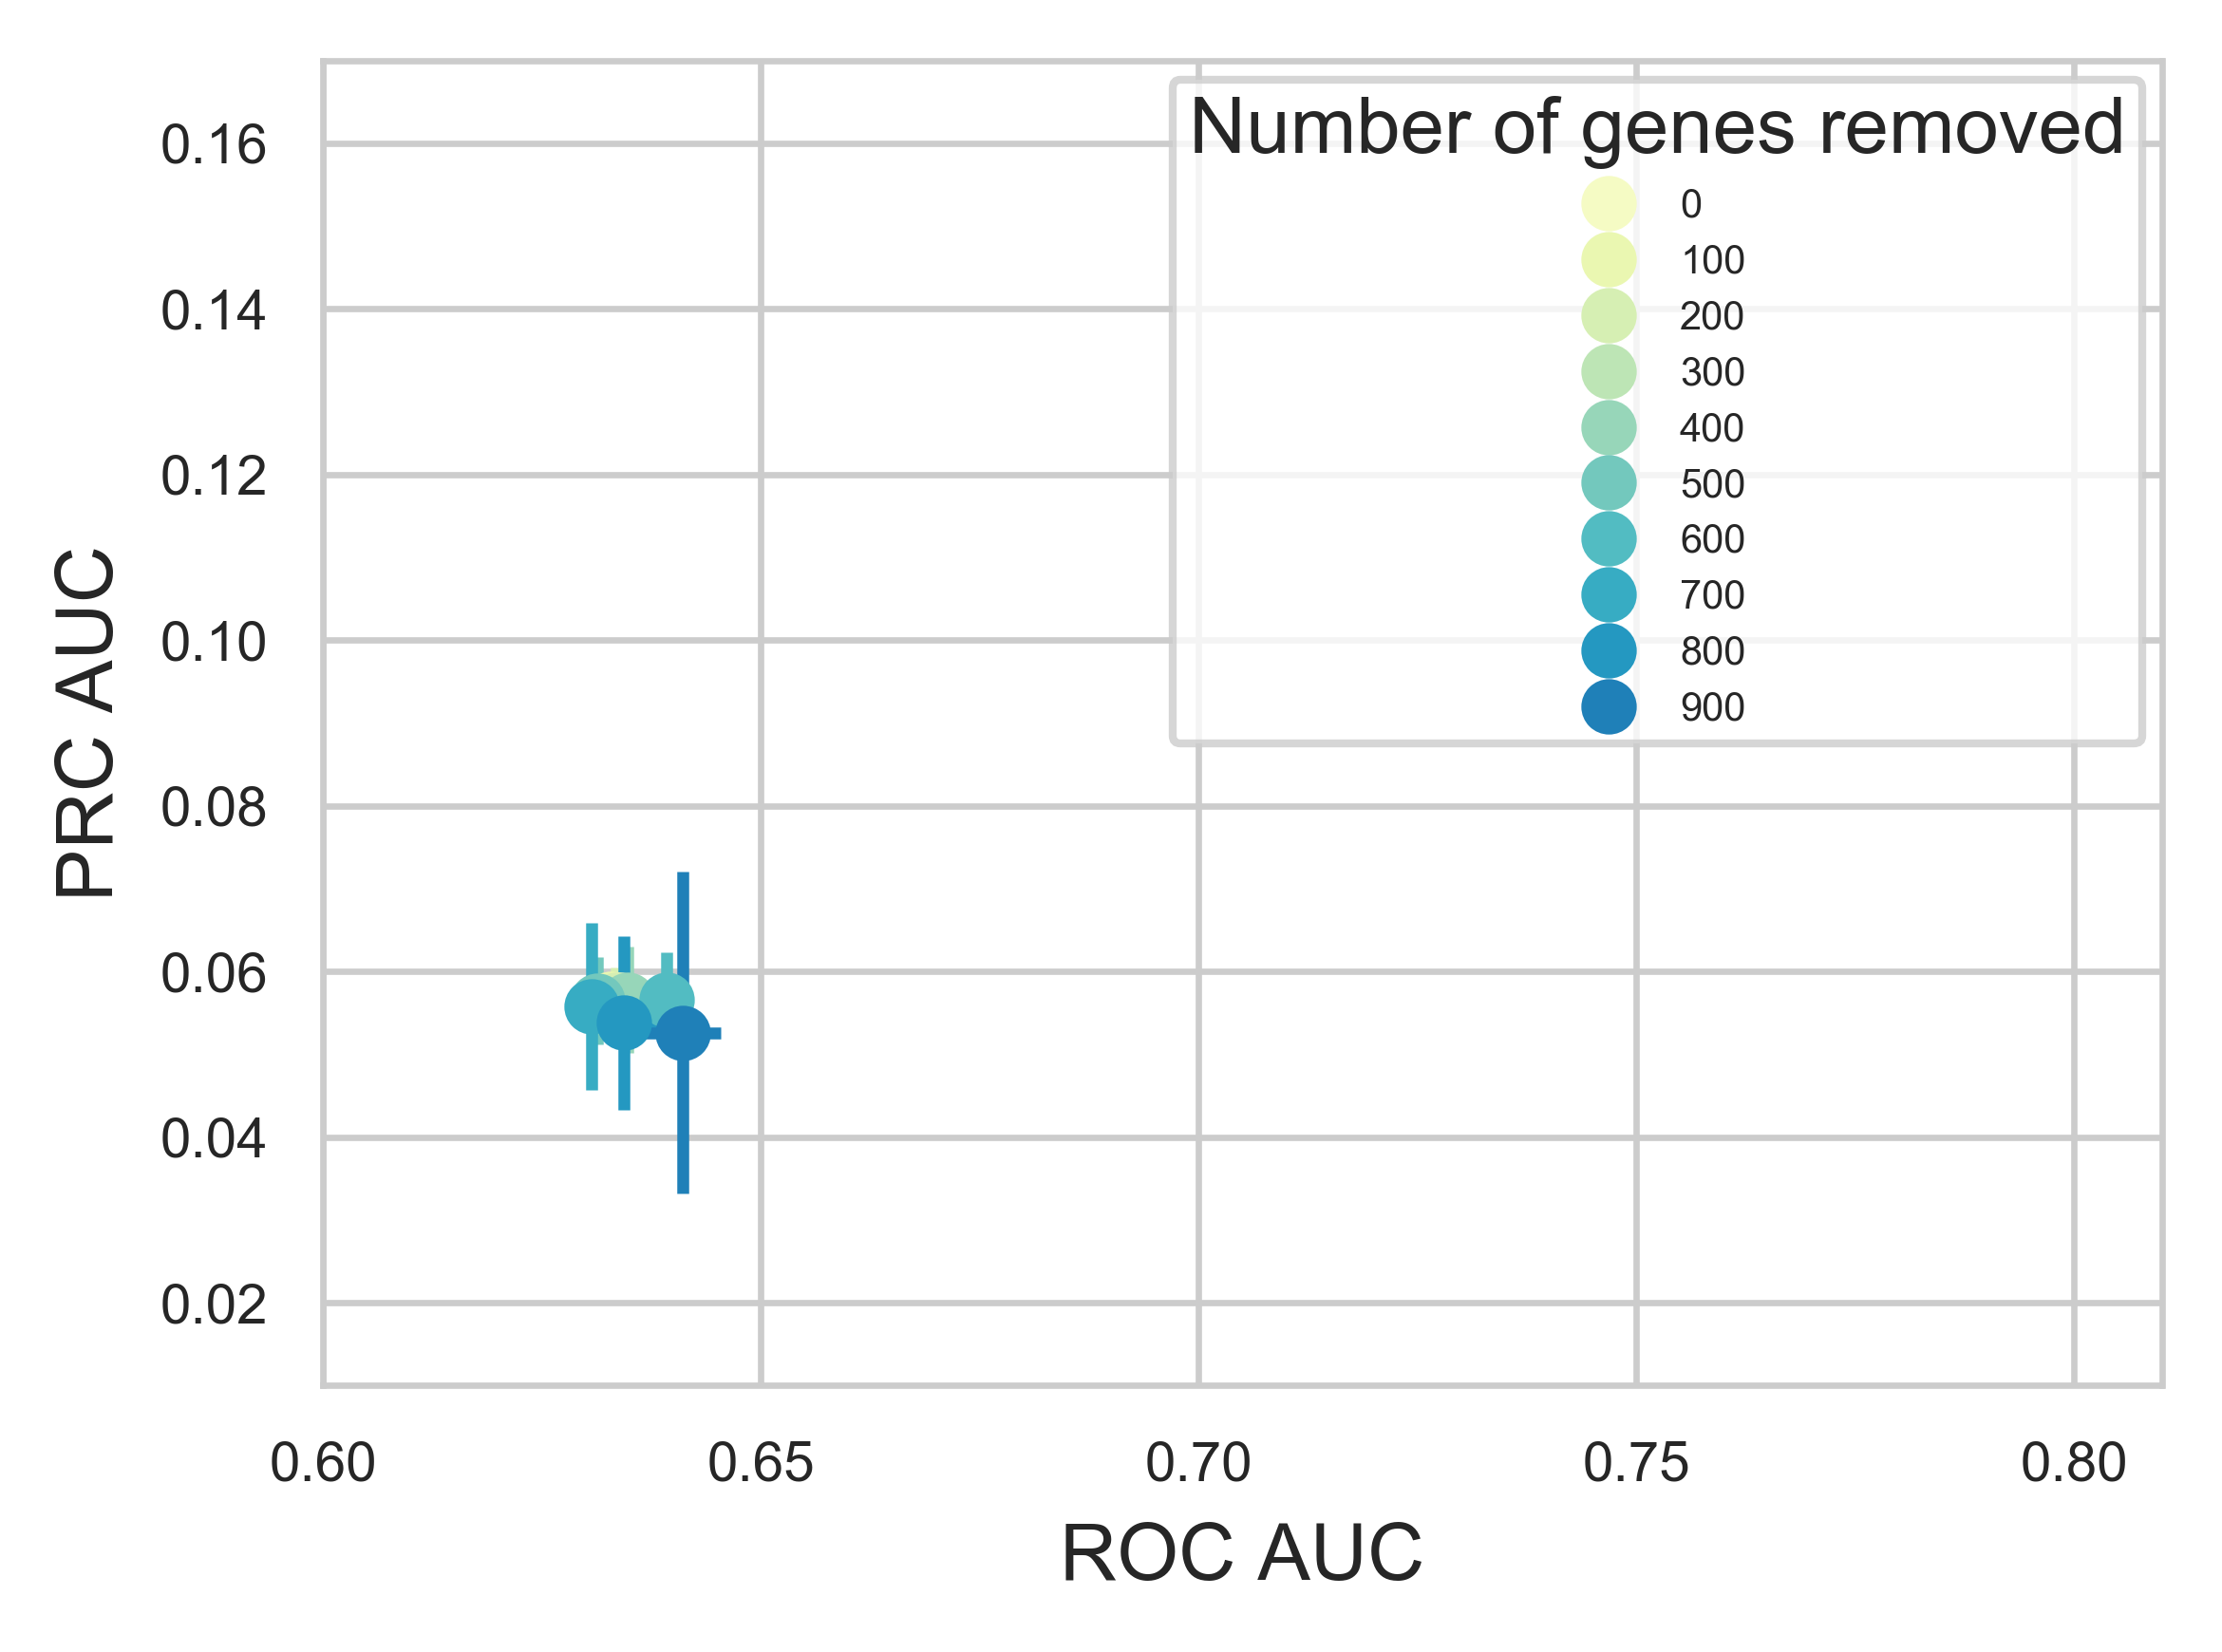

In [50]:
plt.figure(dpi=600,figsize=(4,3))
pal=sns.color_palette('YlGnBu',14)
groups=list(range(0,1000,100))
for j in range(10):
    i=groups[j]
    plt.plot([results_rnd.loc[i,'ROC']],[results_rnd.loc[i,'PRC']],'o',color=pal[j])
    plt.errorbar(results_rnd.loc[i,'ROC'],results_rnd.loc[i,'PRC'],
                 results_rnd.loc[i,'ROS_std'],results_rnd.loc[i,'PRC_std'],color=pal[j])
plt.xticks(size=7)
plt.yticks(size=7)
plt.legend(range(0,1000,100),title='Number of genes removed',prop={'size':5})
plt.xlabel('ROC AUC',size=10)
plt.ylabel('PRC AUC',size=10)
plt.xlim(0.6,0.81)
plt.ylim(0.01,0.17)
plt.tight_layout()
plt.savefig('../figures/raw/SFig4C.pdf')

The important effect of cell viaiblity signature is not so suprising in the CTRP dataset (as here mostly toxic drugs are used - anticancer compounds). To further analyse the confounding effect of cell viability, we can repear this analysis using a larger drug dataset, from the Repurposing Hub.

In [52]:
# read repurposing hub data
repurposing=pd.read_csv('../data/Repurposing/repurposing_drugs_20180907.txt',sep='\t',encoding='latin',
                    header=0,index_col=None,skiprows=9,)
repurposing_meta=pd.read_csv('../data/Repurposing//repurposing_samples_20180907.txt',sep='\t',encoding='latin',
                    header=0,index_col=None,skiprows=9)

In [53]:
repurposing_meta['broad_id']=repurposing_meta['broad_id'].apply(lambda x: '-'.join(x.split('-')[:2]))
repurposing_meta=repurposing_meta[['broad_id','pert_iname']]
repurposing=repurposing[['pert_iname','moa','target']]
repurposing=pd.merge(repurposing,repurposing_meta)

In [54]:
# use only drugs with known moa / target
fil=~(pd.isnull(repurposing['moa']) & pd.isnull(repurposing['target']))
repurposing=repurposing[fil]

In [55]:
all_moas=[]
all_targets=[]
for i in repurposing.index:
    if not pd.isnull(repurposing.loc[i,'target']):
        all_targets+=repurposing.loc[i,'target'].split('|')
    if  not pd.isnull(repurposing.loc[i,'moa']):
        all_moas+=repurposing.loc[i,'moa'].split('|')

In [56]:
moa_matrix=pd.DataFrame(0,index=list(set(repurposing['broad_id'])),columns=list(set(all_moas)|set(all_targets)))

In [57]:
inhibitory_words=set(['inhibitor','blocker','antagonist','inihibitor'])
for i in repurposing.index:
    brd=repurposing.loc[i,'broad_id']
    if not pd.isnull(repurposing.loc[i,'moa']):
        moas=repurposing.loc[i,'moa'].split('|')
    else:
        moas=[]
    if not pd.isnull(repurposing.loc[i,'target']):
        s=1
        targets=repurposing.loc[i,'target'].split('|')
        if len(set((' '.join(moas)).split())&inhibitory_words)>0:
            s=-1
    else:
        targets=[]
    moa_matrix.loc[brd,moas]=1
    moa_matrix.loc[brd,targets]=s

In [58]:
moa_matrix.to_csv('../results/moa/moa_matrix_repurposing.csv',sep=',')

In [59]:
#we will compare our results with fingerprint based similarities, so will work only with compounds where both data is 
# available
chemichal=pd.read_table('../data/Chemical/LINCS_PertID_SMILES_MorganFP_1024bits.csv',
                       sep=',',header=0,index_col=[0])
chemichal.index=chemichal['CompoundNames']
chemichal=chemichal.iloc[:,:-1]
chemichal=chemichal.astype(int)

In [60]:
cpds=list(set(moa_matrix.index) & set(chemichal.index))
print(len(cpds))
moa_matrix=moa_matrix.loc[cpds]
chemichal=chemichal.loc[cpds]

2865


In [61]:
from cmapPy.pandasGEXpress.parse import parse

In [187]:
#now we create consensus signatures
sig_info_gse92742=pd.read_csv('../data/LINCS/GSE92742/GSE92742_Broad_LINCS_sig_info.txt',
                              sep='\t',header=0,index_col=0,low_memory=False)
sig_info_gse70138=pd.read_csv('../data/LINCS/GSE70138/GSE70138_Broad_LINCS_sig_info.txt',
                              sep='\t',header=0,index_col=0,low_memory=False)

In [188]:
fil=np.in1d(sig_info_gse70138['pert_id'],cpds)
sig_info_gse70138=sig_info_gse70138[fil]
fil=np.in1d(sig_info_gse92742['pert_id'],cpds)
sig_info_gse92742=sig_info_gse92742[fil]

In [10]:
gene_info=pd.read_table('../data/LINCS/GSE92742/GSE92742_Broad_LINCS_gene_info.txt',sep='\t')
fil=gene_info['pr_is_lm']==1 # change the columns name to pr_is_bing if you are interested for all genes
gene_ids = list(gene_info.loc[gene_info.index[fil],'pr_gene_id'].astype(str))

In [226]:
#get singatures
gene_info=pd.read_table('../data/LINCS/GSE92742/GSE92742_Broad_LINCS_gene_info.txt',sep='\t')
fil=gene_info['pr_is_lm']==1 # change the columns name to pr_is_bing if you are interested for all genes
gene_ids = list(gene_info.loc[gene_info.index[fil],'pr_gene_id'].astype(str))
for cpd in cpds:
    fil=sig_info_gse70138['pert_id']==cpd
    sig_ids_gse70138=sig_info_gse70138.index[fil]
    if len(sig_ids_gse70138)>0:
        signature_gse70138=parse('../data/LINCS/GSE70138/GSE70138_Broad_LINCS_Level5_COMPZ_n118050x12328.gctx', 
                          cid=sig_ids_gse70138,rid=gene_ids).data_df.T[gene_ids]
    else:
        signature_gse70138=None
    fil=sig_info_gse92742['pert_id']==cpd
    sig_ids_gse92742=sig_info_gse92742.index[fil]
    if len(sig_ids_gse92742)>0:
        signature_gse92742=parse('../data/LINCS/GSE92742/GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx', 
                          cid=sig_ids_gse92742,rid=gene_ids).data_df.T[gene_ids]
    else:
        signature_gse92742=None  
    if (len(sig_ids_gse70138)+len(sig_ids_gse92742))>0:
        signature=pd.concat([signature_gse70138,signature_gse92742])
        signature.to_csv('../results/moa/signatures/%s.csv' %cpd,sep=',')

Now we will calculate consnsus signatures based on full / reduced signatures, and also using the regression based approach. For the later one we use predicted cell viability values (from cell_death5_prediction.ipynb).

In [63]:
import os

In [64]:
fnames=os.listdir('../results/moa/signatures/')
cpds=[x[:-4] for x in fnames]
consensus_signatures={}
for i in range(0,1000,100):
    genes=gene_correlations.index[i:]
    consensus_signatures[i]=pd.DataFrame(index=cpds,columns=genes)

In [65]:
for cpd in cpds:
    if cpds.index(cpd)%100==0:
        print(cpd)
    signature=pd.read_csv('../results/moa/signatures/%s.csv' % cpd,sep=',',header=0,index_col=0)
    for i in range(0,1000,100):
        genes=gene_correlations.index[i:]
        consensus_signatures[i].loc[cpd,genes]=calc_MODZ(signature[genes])
    

BRD-A14941520
BRD-K89085489
BRD-K68185022
BRD-A31800922
BRD-K57304726
BRD-K08999871
BRD-K83405785
BRD-A62428732
BRD-A33749298
BRD-K67121414
BRD-K47936004
BRD-K70592963
BRD-A17411484
BRD-K04185004
BRD-K45861246
BRD-K16898998
BRD-A07563059
BRD-K51485625
BRD-K94266545
BRD-K29359156
BRD-K93618743
BRD-K75516118
BRD-K55781385
BRD-A82396632
BRD-K86873305
BRD-K57371763
BRD-K49807096
BRD-K97810537
BRD-K76841105


In [66]:
similarity={}
for i in range(0,1000,100):
    similarity[i]=pd.DataFrame(scor(consensus_signatures[i].T)[0],index=consensus_signatures[i].index,
                        columns=consensus_signatures[i].index)

In [67]:
chemichal=pd.read_table('../data/Chemical/LINCS_PertID_SMILES_MorganFP_1024bits.csv',
                       sep=',',header=0,index_col=[0])
chemichal.index=chemichal['CompoundNames']
chemichal=chemichal.iloc[:,:-1].astype(bool)
cpds=list(set(similarity[0].index)&set(chemichal.index))
chemichal=chemichal.loc[cpds]
similarity['chem_1024']=pd.DataFrame(index=cpds,columns=cpds)
for i in similarity['chem_1024'].index:
    similarity['chem_1024'][i]=np.sum(chemichal.loc[i]&chemichal,1)/np.sum(chemichal.loc[i]|chemichal,1)

In [68]:
chemichal=pd.read_table('../data/Chemical/LINCS_PertID_SMILES_MorganFP_256bits.csv',
                       sep=',',header=0,index_col=[0])
chemichal.index=chemichal['CompoundNames']
chemichal=chemichal.iloc[:,:-1].astype(bool)
cpds=list(set(similarity[0].index)&set(chemichal.index))
chemichal=chemichal.loc[cpds]
similarity['chem_256']=pd.DataFrame(index=cpds,columns=cpds)
for i in similarity['chem_256'].index:
    similarity['chem_256'][i]=np.sum(chemichal.loc[i]&chemichal,1)/np.sum(chemichal.loc[i]|chemichal,1)

In [69]:
moa_matrix=pd.read_csv('../results/moa/moa_matrix_repurposing.csv',sep=',',header=0,index_col=0)
moa_matrix=moa_matrix.loc[cpds]

In [70]:
similarity['moa']=pd.DataFrame(0,index=cpds,columns=cpds)
for cpd in cpds:
    stims=moa_matrix.columns[moa_matrix.loc[cpd]==1]
    sim_stims=[]
    for stim in stims:
        sim_stims+=list(moa_matrix.index[moa_matrix[stim]==1])
    inhs=moa_matrix.columns[moa_matrix.loc[cpd]==-1]
    sim_inhs=[]
    for inh in inhs:
        sim_inhs+=list(moa_matrix.index[moa_matrix[inh]==-1])
    sims=list(set(sim_stims)|set(sim_inhs))
    similarity['moa'].loc[cpd,sims]=1

In [71]:
for g in similarity.keys():
    similarity[g]=similarity[g].loc[cpds,cpds]

In [75]:
results=pd.DataFrame(index=range(len(similarity[0].values[np.triu_indices(len(similarity[0]),1)])),
                     columns=similarity.keys())
for g in similarity.keys():
    results[g]=similarity[g].values[np.triu_indices(len(similarity[g]),1)]
for g in similarity.keys():
    if g!='moa':
        results[g]=(results[g]-np.mean(results[g]))/np.std(results[g])
results['sum']=results['chem_1024']+results[0]
results['700sum']=results['chem_1024']+results[700]
results.to_csv('../results/moa/moa_repurposing_predictions.csv',sep=',')

In [3]:
results=pd.read_csv('../results/moa/moa_repurposing_predictions.csv',sep=',',header=0,index_col=0)

/Users/benceszalai/Library/Enthought/Canopy/edm/envs/Python3/lib/python3.5/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


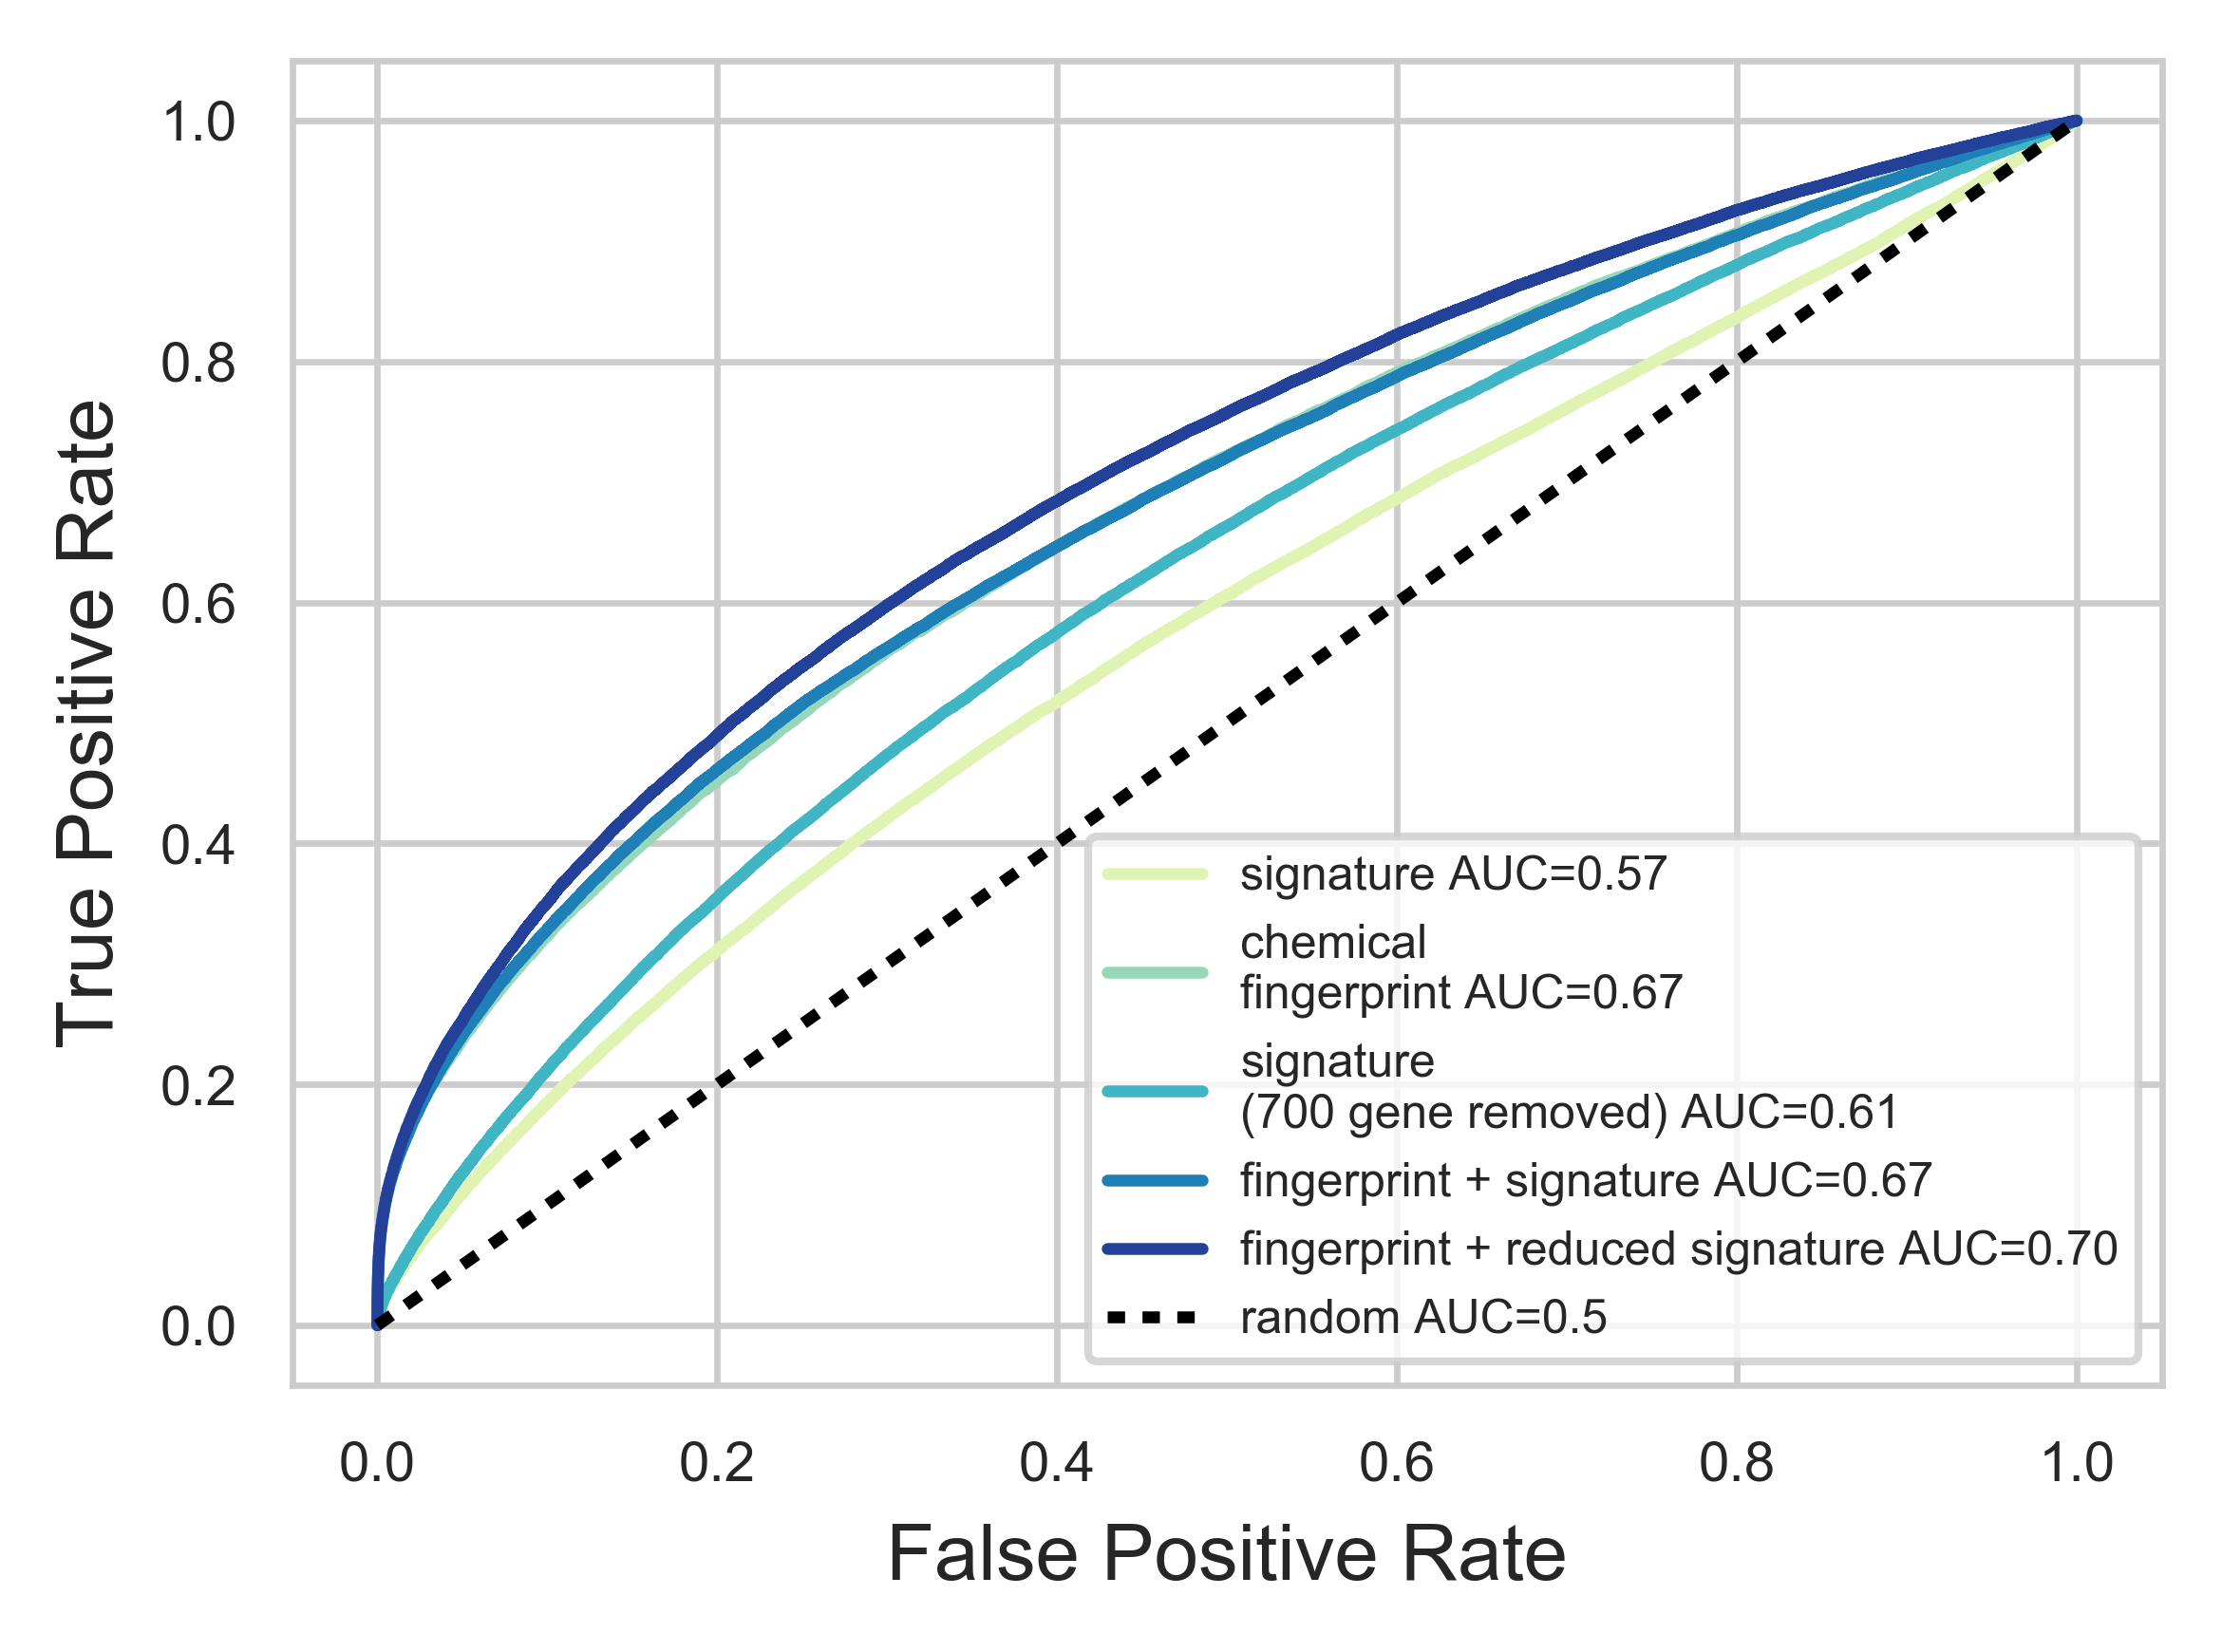

In [24]:
plt.figure(dpi=600,figsize=(4,3))
sns.set_palette('YlGnBu',5)
aucs=[]
labels=['signature','chemical\nfingerprint','signature\n(700 gene removed)','fingerprint + signature',
           'fingerprint + reduced signature']
for g in ['0','chem_1024','700','sum','700sum']:
    fpr,tpr,dummy=ROC(results['moa'],results[g])
    plt.plot(fpr,tpr)
    aucs.append(str(AUC(fpr,tpr))[:4])
plt.plot([0,1],[0,1],':k')
full_labels=[]
for i in range(len(labels)):
    full_labels.append(labels[i] + ' AUC='+aucs[i])
full_labels.append('random AUC=0.5')
plt.legend(full_labels,
          loc=0, prop={'size': 6})
plt.xticks(size=7)
plt.yticks(size=7)
plt.xlabel('False Positive Rate',size=10)
plt.ylabel('True Positive Rate',size=10)
plt.tight_layout()
plt.savefig('../figures/raw/SFig4D.pdf')

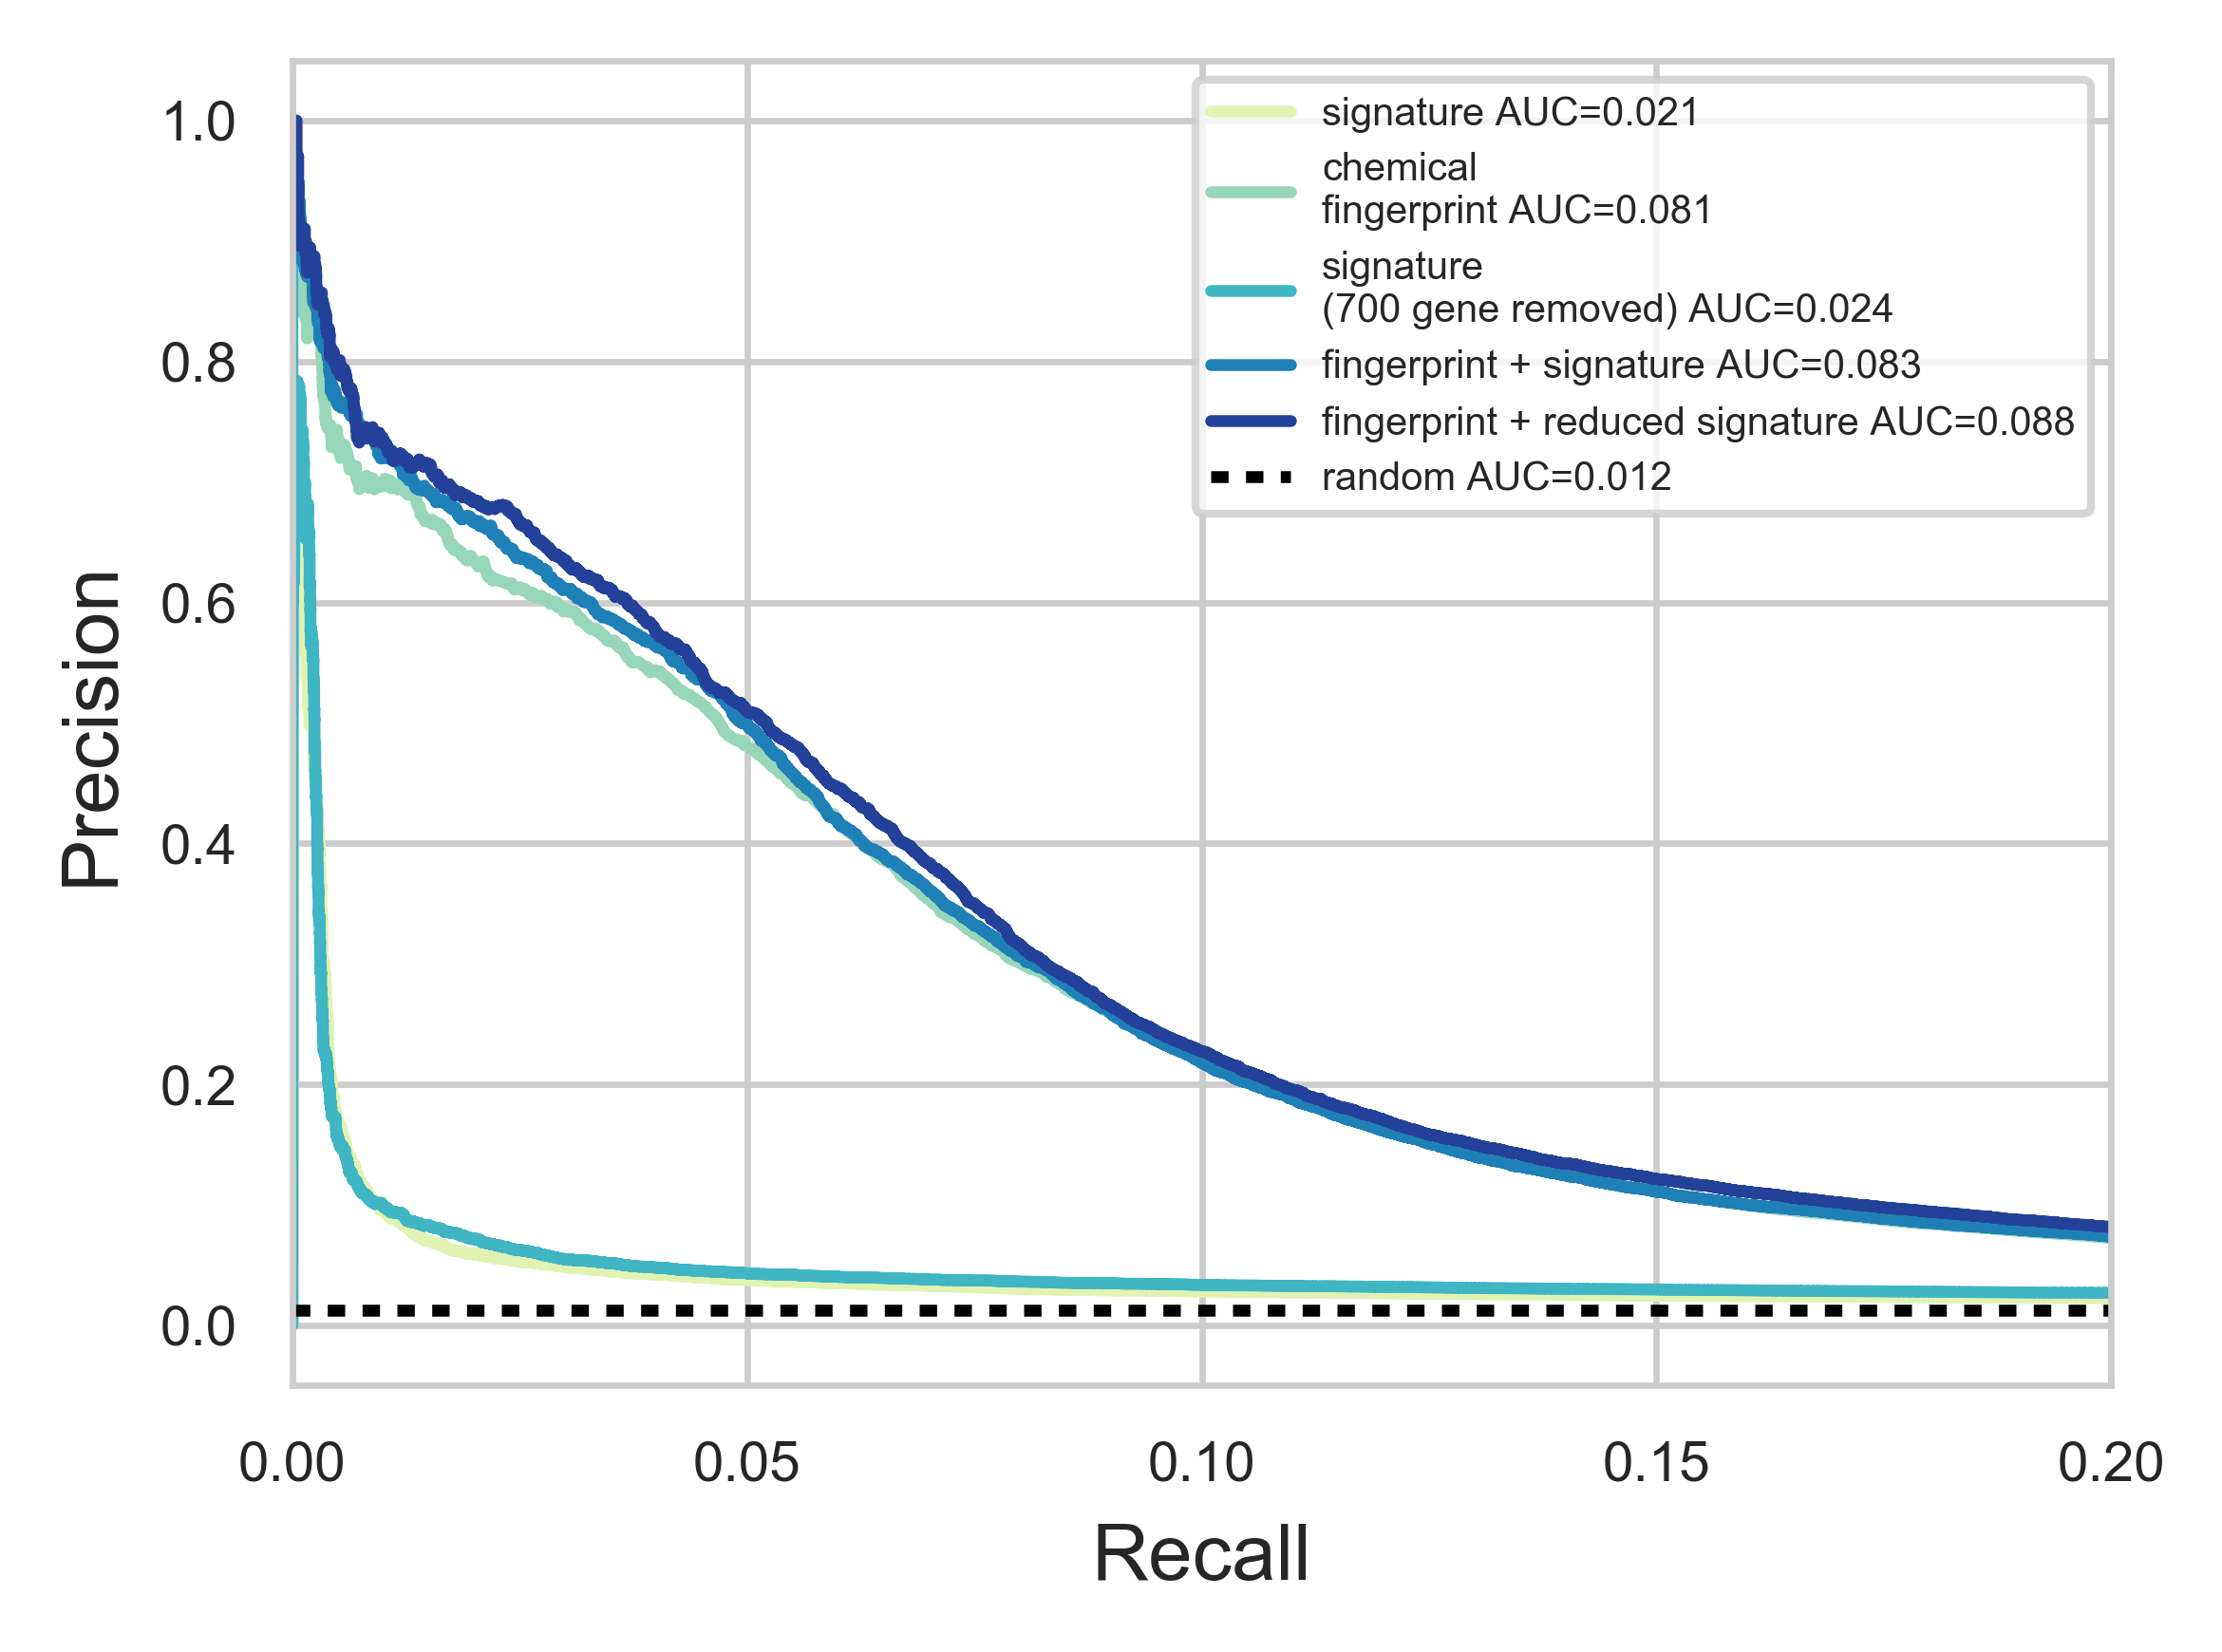

In [27]:
plt.figure(dpi=600,figsize=(4,3))
sns.set_palette('YlGnBu',5)
aucs=[]
labels=['signature','chemical\nfingerprint','signature\n(700 gene removed)','fingerprint + signature',
           'fingerprint + reduced signature']
real_tpr=str(np.sum(results['moa'])/len(results['moa']))
for g in ['0','chem_1024','700','sum','700sum']:
    pre,rec,dummy=PRC(results['moa'],results[g])
    plt.plot(rec,pre)
    aucs.append(str(AUC(rec,pre))[:5])
plt.plot([0,1],[real_tpr,real_tpr],':k')
full_labels=[]
for i in range(len(labels)):
    full_labels.append(labels[i] + ' AUC='+aucs[i])
full_labels.append('random AUC='+str(real_tpr)[:5])
plt.legend(full_labels,loc=0, prop={'size': 5})
plt.xticks(size=7)
plt.yticks(size=7)
plt.xlabel('Recall',size=10)
plt.ylabel('Precision',size=10)
plt.xlim(0,0.2)
plt.tight_layout()
plt.savefig('../figures/raw/SFig4E.pdf')